<a href="https://colab.research.google.com/github/Aledo-Jun/DL-Project/blob/main/DL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

## Import Dependencies

In [ ]:
# importing dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import copy # for deepcopy
import time

# fix the randomization seed for fair test
torch.manual_seed(20020501)
np.random.seed(20020501)

# setting the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device.type

'cpu'

## Load DataSets

In [ ]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load dataset
ds = ['mnist', 'fashion', 'cifar'][1]  # choose one

match ds:
    case 'mnist':
        full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)  # 60,000 datas
        test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
    case 'fashion':
        full_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)  # 60,000
        test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform)
    case 'cifar':
        full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)  # 50,000
        test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)

train_dataset = Subset(full_train_dataset, torch.randperm(len(full_train_dataset)))

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset, batch_size=512, shuffle=False)

## Train / Test Functions

In [ ]:
def train_step(model, device, train_loader, optimizer, epoch, loss_history):
    model.train()
    criterion = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'Training Epoch {epoch}', leave=False)):
        data, target = data.to(device), target.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch} \t Loss: {loss.item():.6f}')

    loss_history.append(loss.item())


def test(model, device, test_loader, accuracy_history, loss_history):
    model.eval()
    criterion = nn.CrossEntropyLoss(reduction='sum')
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Testing', leave=False):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)      # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy  = 100. * correct / len(test_loader.dataset)
    accuracy_history.append(accuracy)
    loss_history.append(test_loss)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')


In [ ]:
def train(model, device, train_loader, optimizer, n_epochs, test_freq=0):
    loss_history = []
    accuracy_history = [] if test_freq != 0 else None
    val_loss_history = [] if test_freq != 0 else None

    start = time.time()
    for epoch in range(1, n_epochs + 1):
        train_step(model, device, train_loader, optimizer, epoch, loss_history)
        if accuracy_history is not None and epoch % test_freq == 0:
            test(model, device, test_loader, accuracy_history, val_loss_history)

    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60: .0f}m {time_elapsed % 60: .0f}s')

    return loss_history, accuracy_history, val_loss_history


## Cross-Validation

In [ ]:
def cross_validate(model, device, optimizer_class, optimizer_params, n_epochs, n_cv, decision_step=5):
    original_model = copy.deepcopy(model)

    # Lists for logging each CV
    total_train_losses = []
    total_val_losses = []
    total_train_accuracies = []
    total_val_accuracies = []

    start = time.time()
    for cv_id in range(1, n_cv + 1):
        print('-'*25,f'[CV #{cv_id}]','-'*25 ,sep='')

        # Initialize new model and optimizer
        model = copy.deepcopy(original_model)
        optimizer = optimizer_class(model.parameters(), **optimizer_params)

        # Partition the dataset into 7:3 (train:validation)
        sz = len(full_train_dataset)
        slice_idx = int(0.7 * sz)
        random_perm = torch.randperm(sz)
        train_dataset = Subset(full_train_dataset, random_perm[:slice_idx])
        val_dataset = Subset(full_train_dataset, random_perm[slice_idx:])

        # Data loaders
        train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

        criterion = nn.CrossEntropyLoss()

        # Lists to store per-epoch metrics
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        # Optimal model
        step_model = copy.deepcopy(model)
        step_val_loss = -1
        opt_model = copy.deepcopy(model)
        opt_val_loss = -1
        opt_found = False

        # Training loop
        for epoch in range(1, n_epochs + 1):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            # Training
            for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'Training Epoch{epoch}', leave=False)):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()

                # Forward pass
                outputs = model(data)
                loss = criterion(outputs, target)

                # Backward pass and update
                loss.backward()
                optimizer.step()

                # metric calculation
                running_loss += loss.item() * data.size(0)
                _, predicted = outputs.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = 100. * correct / total
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)

            # Validation
            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for data, target in tqdm(val_loader, desc='Validating', leave=False):
                    data, target = data.to(device), target.to(device)
                    outputs = model(data)
                    loss = criterion(outputs, target)

                    val_running_loss += loss.item() * data.size(0)
                    _, predicted = outputs.max(1)
                    val_total += target.size(0)
                    val_correct += predicted.eq(target).sum().item()

            val_epoch_loss = val_running_loss / len(val_loader.dataset)
            val_epoch_acc = 100. * val_correct / val_total
            val_losses.append(val_epoch_loss)
            val_accuracies.append(val_epoch_acc)

            # Optimal model triggering
            if not opt_found:
                if step_val_loss == -1 or step_val_loss > val_epoch_loss:
                    step_model = copy.deepcopy(model)
                    step_val_loss = val_epoch_loss
                if (epoch + 1) % decision_step == 0 and (opt_val_loss == -1 or opt_val_loss > step_val_loss or epoch + 1 == n_epochs):
                    opt_model = copy.deepcopy(model)
                    opt_val_loss = step_val_loss
                else:
                    opt_found = True

            print(f'Epoch {epoch}/{n_epochs}, '
                f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
                f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%')

        # Store results for this CV
        total_train_losses.append(train_losses)
        total_val_losses.append(val_losses)
        total_train_accuracies.append(train_accuracies)
        total_val_accuracies.append(val_accuracies)

        print('-'*80)
    time_elabsed = time.time() - start
    print(f"CV completed in {time_elabsed//60: .0f}m {time_elabsed%60: .0f}s")

    # Visualization
    fig, axs = plt.subplots(n_cv, 2, constrained_layout=True)
    fig.set_size_inches(12, 10)

    for cv_id in range(0, n_cv):
        # Loss
        ax1 = axs[cv_id][0]
        ax1.plot(total_train_losses[cv_id], label='Training Loss')
        ax1.plot(total_val_losses[cv_id], label='Validation Loss')
        ax1.set_title(f'Loss of CV {cv_id + 1}')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Accuracy
        ax2 = axs[cv_id][1]
        ax2.plot(total_train_accuracies[cv_id], label='Training Accuracy')
        ax2.plot(total_val_accuracies[cv_id], label='Validation Accuracy')
        ax2.set_title(f'Accuracy of CV {cv_id + 1}')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()

    # Average Validation Metrics
    avg_val_losses = np.mean(total_val_losses, axis=0)
    avg_val_accuracies = np.mean(total_val_accuracies, axis=0)

    ax1 = axs[-1][0]
    ax1.plot(avg_val_losses, label='Average Validation Loss')
    ax1.set_title('Average Validation Loss Across CVs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2 = axs[-1][1]
    ax2.plot(avg_val_accuracies, label='Average Validation Accuracy')
    ax2.set_title('Average Validation Accuracy Across CVs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.show()

    # For full automation
    from google.colab import files
    import os

    ### Store results to csv file
    # Losses
    with open(f'./{str(optimizer).split()[0]}-{str(model).split("(")[0]}-{ds}-losses.csv', mode='w') as f:
        print(*[f'tloss_{i},tacc_{i},vloss_{i},vacc_{i}' for i in range(1, n_cv+1)], sep=',', file=f)
        for i in range(n_epochs):
            s = []
            for cv_id in range(n_cv):
                s.append(total_train_losses[cv_id][i])
                s.append(total_train_accuracies[cv_id][i])
                s.append(total_val_losses[cv_id][i])
                s.append(total_val_accuracies[cv_id][i])
            print(*s, sep=',', file=f)

        files.download(f.name)  # auto download

    # Velocity
    with open(f'./{str(optimizer).split()[0]}-{str(model).split("(")[0]}-{ds}-velocity.csv', mode='w') as f:
        print(*[f'v_{i}' for i in range(1, n_cv+1)], sep=',', file=f)
        for i in range(len(optimizer.v_history)):
            s = []
            for cv_id in range(n_cv):
                s.append(float(optimizer.v_history[i]))
            print(*s, sep=',', file=f)

        files.download(f.name)  # auto download

    # Store Optimal model
    checkpoint = os.path.join(f'./{str(optimizer).split()[0]}-{str(model).split("(")[0]}-{ds}-optimal.pt')
    torch.save(model.state_dict(), checkpoint)
    files.download(checkpoint)  # auto download


# Experiments

## Define Network

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, input_channels):
        super(ResNet18, self).__init__()
        self.resnet = torchvision.models.resnet18()

        # revise some layers to match our dataset
        self.resnet.conv1 = nn.Conv2d(input_channels, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)

    def forward(self, x):
        x = self.resnet(x)
        return x


In [ ]:
class MobileNetV2(nn.Module):
    def __init__(self, input_channels):
        super(MobileNetV2,self).__init__()
        self.mobilenet = torchvision.models.mobilenet_v2()

        # revise some layers to match our dataset
        self.mobilenet.features[0][0] = nn.Conv2d(input_channels, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        self.mobilenet.features[2].conv[1][0] = nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96, bias=False)
        self.mobilenet.features[4].conv[1][0] = nn.Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        self.mobilenet.classifier[1] = nn.Linear(in_features=1280, out_features=10, bias=True)

    def forward(self,x):
        x = self.mobilenet(x)
        return x

## Define Custom Optimizers

### Vanilla SGDM

In [ ]:
class SGDWithStaticMomentum(optim.Optimizer):
    def __init__(self, params, lr=0.01, gamma1=0.1, eps=1e-8):
        defaults = dict(lr=lr, gamma1=gamma1, eps=eps)
        super(SGDWithStaticMomentum, self).__init__(params, defaults)
        self.global_step = 0

        self.v_history = []


    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        self.global_step += 1

        max_v = torch.tensor(0).to(device)
        for group in self.param_groups:
            lr = group['lr']
            gamma1 = group['gamma1']
            eps = group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data

                # State initialization
                state = self.state[p]

                # State variable initialization or retrieval
                if 'velocity' not in state:
                    state['velocity'] = torch.zeros_like(p.data)

                v = state['velocity']

                v *= 1 - gamma1
                v += -lr * grad

                # Update parameters
                p.data += v

                max_v = max(max_v, v.mean())

        self.v_history.append(max_v)

        return loss


### Norm-$Re$

In [ ]:
class SGDWithVariableMomentum_normalized_Re(optim.Optimizer):
    def __init__(self, params, lr=0.01, Re_crit=1, gamma1=0.1, gamma2=0.9, k=1, eps=1e-8):
        defaults = dict(lr=lr, Re_crit=Re_crit, gamma1=gamma1, gamma2=gamma2, k=k, eps=eps)
        super(SGDWithVariableMomentum_normalized_Re, self).__init__(params, defaults)
        self.global_step = 0

        self.gamma_history = []
        self.v_history = []


    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        self.global_step += 1

        max_gamma = torch.tensor(0).to(device)
        max_v = torch.tensor(0).to(device)
        for group in self.param_groups:
            lr = group['lr']
            Re_crit = group['Re_crit']
            gamma1 = group['gamma1']
            gamma2 = group['gamma2']
            k = group['k']
            eps = group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data

                # State initialization
                state = self.state[p]

                # State variable initialization or retrieval
                if 'step' not in state:
                    state['step'] = 0
                state['step'] += 1

                if 'velocity' not in state:
                    state['velocity'] = torch.zeros_like(p.data)
                if 'running_mean_v' not in state:
                    state['running_mean_v'] = torch.zeros_like(p.data)
                if 'running_M2_v' not in state:
                    state['running_M2_v'] = torch.zeros_like(p.data)

                if 'running_mean_g' not in state:
                    state['running_mean_g'] = torch.zeros_like(p.data)
                if 'running_M2_g' not in state:
                    state['running_M2_g'] = torch.zeros_like(p.data)

                v = state['velocity']
                v_abs = v.abs()

                # Compute running standard deviation
                running_var_v = state['running_M2_v'] / state['step']
                running_std_v = torch.sqrt(running_var_v) + eps

                running_var_g = state['running_M2_g'] / state['step']
                running_std_g = torch.sqrt(running_var_g) + eps

                # Compute Reynolds-like number
                Re_v = (v_abs - state['running_mean_v']) / running_std_v
                Re_g = (grad - state['running_mean_g']) / running_std_g + eps
                Re = abs(Re_v / Re_g)

                ### Online variance calculation @see https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm
                delta1 = v_abs - state['running_mean_v']
                state['running_mean_v'] += delta1 / state['step']
                delta2 = v_abs - state['running_mean_v']
                state['running_M2_v'] += delta1 * delta2

                delta3 = grad - state['running_mean_g']
                state['running_mean_g'] += delta3 / state['step']
                delta4 = grad - state['running_mean_g']
                state['running_M2_g'] += delta3 * delta4

                # Compute S(Re) = logistic(k, Re) for a smooth transition
                # k indicates the steepness of the transition
                S = torch.clamp(2. / (1. + torch.exp(-k * (Re - Re_crit))) - 1., min=0)

                # Compute variable friction (gamma)
                # as Re -> thd, S(Re) -> 0, therfore, gamma -> gamma1 (original def)
                # as Re -> inf, S(Re) -> 1. therfore, gamma -> gamma2
                gamma = gamma1 + (gamma2 - gamma1) * S

                assert not torch.isnan(gamma).any(), 'gamma has nan value'
                assert torch.all(0 <= gamma), 'gamma < 0'

                # Update Momentum
                v *= 1 - gamma
                v += -lr * grad

                # Update parameters
                p.data += v

                max_gamma = max(max_gamma, gamma.mean())
                max_v = max(max_v, v.mean())

        self.gamma_history.append(max_gamma)
        self.v_history.append(max_v)

        return loss

### History scaling $v$

In [ ]:
class SGDWithVariableMomentum_history_scaling_v(optim.Optimizer):
    def __init__(self, params, lr=0.01, Re_crit=1, gamma1=0.1, gamma2=0.9, k=1, sigma=-0.25, eps=1e-8):
        defaults = dict(lr=lr, Re_crit=Re_crit, gamma1=gamma1, gamma2=gamma2, k=k, sigma=sigma, eps=eps)
        super(SGDWithVariableMomentum_history_scaling_v, self).__init__(params, defaults)
        self.global_step = 0

        self.gamma_history = []
        self.v_history = []

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        self.global_step += 1

        max_gamma = torch.tensor(0).to(device)
        max_v = torch.tensor(0).to(device)
        for group in self.param_groups:
            lr = group['lr']
            Re_crit = group['Re_crit']
            gamma1 = group['gamma1']
            gamma2 = group['gamma2']
            k = group['k']
            sigma = group['sigma']
            eps = group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data

                # State initialization
                state = self.state[p]

                # State variable initialization or retrieval
                if 'step' not in state:
                    state['step'] = 0
                state['step'] += 1

                if 'velocity' not in state:
                    state['velocity'] = torch.zeros_like(p.data)
                if 'running_mean_v' not in state:
                    state['running_mean_v'] = torch.zeros_like(p.data)
                if 'running_M2_v' not in state:
                    state['running_M2_v'] = torch.zeros_like(p.data)

                v = state['velocity']

                v_abs = v.abs()

                # Compute running standard deviation
                running_var_v = state['running_M2_v'] / state['step']
                running_std_v = torch.sqrt(running_var_v) + eps

                # Scale v using whole v history
                v_scaled = v_abs / torch.clamp(state['running_mean_v'] + sigma * running_std_v, min=eps)

                # Compute Reynolds-like number
                Re = v_scaled
                new_gamma2 = 1 / (1 + (2.75 - sigma) * torch.std(v_scaled))  # 99.7%

                # Compute S(Re) = logistic(k, Re) for a smooth transition
                # k indicates the steepness of the transition
                S = 2. / (1. + torch.exp(-k * (v_scaled - Re_crit))) - 1.

                # Compute variable friction(gamma)
                gamma = gamma1 + (new_gamma2 * v_scaled - gamma1) * S
                # Re-scale gamma and clamp it to be positive
                gamma_scaled = torch.clamp(lr * gamma, min=0, max=1)

                # Update Momentum
                v *= 1 - gamma_scaled
                v += -lr * grad

                # Update parameters
                p.data += v

                max_gamma = max(max_gamma, gamma.mean())
                max_v = max(max_v, v.mean())

        self.gamma_history.append(max_gamma)
        self.v_history.append(max_v)

        return loss

### Instant scaling $v$

In [ ]:
class SGDWithVariableMomentum_instant_scaling_v(optim.Optimizer):
    def __init__(self, params, lr=0.01, Re_crit=1, gamma1=0.1, gamma2=0.9, k=1, sigma=-0.25, eps=1e-8):
        defaults = dict(lr=lr, Re_crit=Re_crit, gamma1=gamma1, gamma2=gamma2, k=k, sigma=sigma, eps=eps)
        super(SGDWithVariableMomentum_instant_scaling_v, self).__init__(params, defaults)
        self.global_step = 0

        self.gamma_history = []
        self.v_history = []


    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        self.global_step += 1

        max_gamma = torch.tensor(0).to(device)
        max_v = torch.tensor(0).to(device)
        for group in self.param_groups:
            lr = group['lr']
            Re_crit = group['Re_crit']
            gamma1 = group['gamma1']
            gamma2 = group['gamma2']
            k = group['k']
            sigma = group['sigma']
            eps = group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data

                # State initialization
                state = self.state[p]

                # State variable initialization or retrieval
                if 'velocity' not in state:
                    state['velocity'] = torch.zeros_like(p.data)

                v = state['velocity']

                v_abs = v.abs()

                # Scale v using only current v_abs
                v_scaled = v_abs / torch.clamp(v_abs.mean() + sigma * v_abs.std(), min=eps)

                # Compute Reynolds-like number
                Re = v_scaled
                new_gamma2 = 1 / (1 + (2.75 - sigma) * torch.std(v_scaled))  # 99.7%

                # Compute S(Re) = logistic(k, Re) for a smooth transition
                # k indicates the steepness of the transition
                S = 2. / (1. + torch.exp(-k * (v_scaled - Re_crit))) - 1.

                # Compute variable friction(gamma)
                gamma = gamma1 + (new_gamma2 * v_scaled - gamma1) * S
                # Re-scale gamma and clamp it to be positive
                gamma_scaled = torch.clamp(lr * gamma, min=0, max=1)

                # Update Momentum
                v *= 1 - gamma_scaled
                v += -lr * grad

                # Update parameters
                p.data += v

                max_gamma = max(max_gamma, gamma.mean())
                max_v = max(max_v, v.mean())

        self.gamma_history.append(max_gamma)
        self.v_history.append(max_v)

        return loss

### Mixed version

In [ ]:
class SGDWithVariableMomentum_normalized_Re_with_history_scaling(optim.Optimizer):
    def __init__(self, params, lr=0.01, Re_crit=1, gamma1=0.1, gamma2=0.9, k=1, sigma=-0.25, eps=1e-8):
        defaults = dict(lr=lr, Re_crit=Re_crit, gamma1=gamma1, gamma2=gamma2, k=k, sigma=sigma, eps=eps)
        super(SGDWithVariableMomentum_normalized_Re_with_history_scaling, self).__init__(params, defaults)
        self.global_step = 0

        self.gamma_history = []
        self.v_history = []


    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        self.global_step += 1

        max_gamma = torch.tensor(0).to(device)
        max_v = torch.tensor(0).to(device)
        for group in self.param_groups:
            lr = group['lr']
            Re_crit = group['Re_crit']
            gamma1 = group['gamma1']
            gamma2 = group['gamma2']
            k = group['k']
            sigma = group['sigma']
            eps = group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data

                # State initialization
                state = self.state[p]

                # State variable initialization or retrieval
                if 'step' not in state:
                    state['step'] = 0
                state['step'] += 1

                if 'velocity' not in state:
                    state['velocity'] = torch.zeros_like(p.data)
                if 'running_mean_v' not in state:
                    state['running_mean_v'] = torch.zeros_like(p.data)
                if 'running_M2_v' not in state:
                    state['running_M2_v'] = torch.zeros_like(p.data)

                if 'running_mean_g' not in state:
                    state['running_mean_g'] = torch.zeros_like(p.data)
                if 'running_M2_g' not in state:
                    state['running_M2_g'] = torch.zeros_like(p.data)

                v = state['velocity']
                v_abs = v.abs()

                # Compute running standard deviation
                running_var_v = state['running_M2_v'] / state['step']
                running_std_v = torch.sqrt(running_var_v) + eps

                running_var_g = state['running_M2_g'] / state['step']
                running_std_g = torch.sqrt(running_var_g) + eps

                # Compute Reynolds-like number
                Re_v = (v_abs - state['running_mean_v']) / running_std_v
                Re_g = (grad - state['running_mean_g']) / running_std_g + eps
                Re = abs(Re_v / Re_g)

                ### Online variance calculation @see https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm
                delta1 = v_abs - state['running_mean_v']
                state['running_mean_v'] += delta1 / state['step']
                delta2 = v_abs - state['running_mean_v']
                state['running_M2_v'] += delta1 * delta2

                delta3 = grad - state['running_mean_g']
                state['running_mean_g'] += delta3 / state['step']
                delta4 = grad - state['running_mean_g']
                state['running_M2_g'] += delta3 * delta4

                # Compute S(Re) = logistic(k, Re) for a smooth transition
                # k indicates the steepness of the transition
                S = torch.clamp(2. / (1. + torch.exp(-k * (Re - Re_crit))) - 1., min=0)

                # Compute variable friction (gamma)
                # as Re -> thd, S(Re) -> 0, therfore, gamma -> gamma1 (original def)
                # as Re -> inf, S(Re) -> 1. therfore, gamma -> gamma2
                v_scaled = v_abs / torch.clamp(state['running_mean_v'] + sigma * running_std_v, min=eps)
                gamma = gamma1 + (gamma2 * v_scaled - gamma1) * S
                gamma_scaled = torch.clamp(lr * gamma, min=0, max=1)

                # Update Momentum
                v *= 1 - gamma_scaled
                v += -lr * grad

                # Update parameters
                p.data += v

                max_gamma = max(max_gamma, gamma_scaled.mean())
                max_v = max(max_v, v.mean())

        self.gamma_history.append(max_gamma)
        self.v_history.append(max_v)

        return loss

In [ ]:
class SGDWithVariableMomentum_normalized_Re_with_instant_scaling(optim.Optimizer):
    def __init__(self, params, lr=0.01, Re_crit=1, gamma1=0.1, gamma2=0.9, k=1, sigma=-0.25, eps=1e-8):
        defaults = dict(lr=lr, Re_crit=Re_crit, gamma1=gamma1, gamma2=gamma2, k=k, sigma=sigma, eps=eps)
        super(SGDWithVariableMomentum_normalized_Re_with_instant_scaling, self).__init__(params, defaults)
        self.global_step = 0

        self.gamma_history = []
        self.v_history = []


    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        self.global_step += 1

        max_gamma = torch.tensor(0).to(device)
        max_v = torch.tensor(0).to(device)
        for group in self.param_groups:
            lr = group['lr']
            Re_crit = group['Re_crit']
            gamma1 = group['gamma1']
            gamma2 = group['gamma2']
            k = group['k']
            sigma = group['sigma']
            eps = group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data

                # State initialization
                state = self.state[p]

                # State variable initialization or retrieval
                if 'step' not in state:
                    state['step'] = 0
                state['step'] += 1

                if 'velocity' not in state:
                    state['velocity'] = torch.zeros_like(p.data)
                if 'running_mean_v' not in state:
                    state['running_mean_v'] = torch.zeros_like(p.data)
                if 'running_M2_v' not in state:
                    state['running_M2_v'] = torch.zeros_like(p.data)

                if 'running_mean_g' not in state:
                    state['running_mean_g'] = torch.zeros_like(p.data)
                if 'running_M2_g' not in state:
                    state['running_M2_g'] = torch.zeros_like(p.data)

                v = state['velocity']
                v_abs = v.abs()

                # Compute running standard deviation
                running_var_v = state['running_M2_v'] / state['step']
                running_std_v = torch.sqrt(running_var_v) + eps

                running_var_g = state['running_M2_g'] / state['step']
                running_std_g = torch.sqrt(running_var_g) + eps

                # Compute Reynolds-like number
                Re_v = (v_abs - state['running_mean_v']) / running_std_v
                Re_g = (grad - state['running_mean_g']) / running_std_g + eps
                Re = abs(Re_v / Re_g)

                ### Online variance calculation @see https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm
                delta1 = v_abs - state['running_mean_v']
                state['running_mean_v'] += delta1 / state['step']
                delta2 = v_abs - state['running_mean_v']
                state['running_M2_v'] += delta1 * delta2

                delta3 = grad - state['running_mean_g']
                state['running_mean_g'] += delta3 / state['step']
                delta4 = grad - state['running_mean_g']
                state['running_M2_g'] += delta3 * delta4

                # Compute S(Re) = logistic(k, Re) for a smooth transition
                # k indicates the steepness of the transition
                S = torch.clamp(2. / (1. + torch.exp(-k * (Re - Re_crit))) - 1., min=0)

                # Compute variable friction (gamma)
                # as Re -> thd, S(Re) -> 0, therfore, gamma -> gamma1 (original def)
                # as Re -> inf, S(Re) -> 1. therfore, gamma -> gamma2
                v_scaled = v_abs / torch.clamp(torch.mean(v_abs) + sigma * torch.std(v_abs), min=eps)
                gamma = gamma1 + (gamma2 * v_scaled - gamma1) * S
                gamma_scaled = torch.clamp(lr*gamma, min=0, max=1)

                # Update Momentum
                v *= 1 - gamma_scaled
                v += -lr * grad

                # Update parameters
                p.data += v

                max_gamma = max(max_gamma, gamma_scaled.mean())
                max_v = max(max_v, v.mean())

        self.gamma_history.append(max_gamma)
        self.v_history.append(max_v)

        return loss

## Initialize Optimizers

In [ ]:
# Vanilla
optimizer1 = SGDWithStaticMomentum
optimizer_params1 = {
    'lr': 0.01,
    'gamma1': 0.1,
}

In [ ]:
# Normalized Re
optimizer2 = SGDWithVariableMomentum_normalized_Re
optimizer_params2 = {
    'lr': 0.01,
    'Re_crit': 0.5,
    'gamma1': 0.1,
    'gamma2': 0.9,
    'k': 1,
}

In [ ]:
# Instant scaling v
optimizer3 = SGDWithVariableMomentum_instant_scaling_v
optimizer_params3 = {
    'lr': 0.01,
    'Re_crit': 0.5,
    'gamma1': 0.1,
    'gamma2': 0.9,
    'k': 1,
    'sigma': -0.25
}

In [ ]:
# History scaling v
optimizer4 = SGDWithVariableMomentum_history_scaling_v
optimizer_params4 = {
    'lr': 0.01,
    'Re_crit': 0.5,
    'gamma1': 0.1,
    'gamma2': 0.9,
    'k': 1,
    'sigma': -0.25
}

In [ ]:
# Normalized Re + instant scaling v
optimizer5 = SGDWithVariableMomentum_normalized_Re_with_instant_scaling
optimizer_params5 = {
    'lr': 0.01,
    'Re_crit': 0.5,
    'gamma1': 0.1,
    'gamma2': 0.9,
    'k': 1,
    'sigma': -0.25
}

In [ ]:
# Normalized Re + history scaling v
optimizer6 = SGDWithVariableMomentum_normalized_Re_with_history_scaling
optimizer_params6 = {
    'lr': 0.01,
    'Re_crit': 0.5,
    'gamma1': 0.1,
    'gamma2': 0.9,
    'k': 1,
    'sigma': -0.25
}

## Initialize Network

In [ ]:
model = ResNet18(3 if ds=='cifar' else 1).to(device)

model1 = copy.deepcopy(model)
model2 = copy.deepcopy(model)
model3 = copy.deepcopy(model)

In [ ]:
model = MobileNetV2(3 if ds=='cifar' else 1).to(device)

model4 = copy.deepcopy(model)
model5 = copy.deepcopy(model)
model6 = copy.deepcopy(model)

## Cross validation

----------[CV #1]-------------------------


Epoch 1/35, Train Loss: 1.7710, Train Acc: 37.78%, Val Loss: 1.3371, Val Acc: 49.66%


Epoch 2/35, Train Loss: 0.8590, Train Acc: 69.76%, Val Loss: 0.7474, Val Acc: 73.91%


Epoch 3/35, Train Loss: 0.5998, Train Acc: 78.38%, Val Loss: 0.9686, Val Acc: 61.12%


Epoch 4/35, Train Loss: 0.5058, Train Acc: 81.63%, Val Loss: 0.6843, Val Acc: 76.07%


Epoch 5/35, Train Loss: 0.4404, Train Acc: 84.09%, Val Loss: 0.8496, Val Acc: 69.33%


Epoch 6/35, Train Loss: 0.4080, Train Acc: 85.27%, Val Loss: 0.4581, Val Acc: 83.33%


Epoch 7/35, Train Loss: 0.3683, Train Acc: 86.73%, Val Loss: 1.7019, Val Acc: 45.73%


Epoch 8/35, Train Loss: 0.3485, Train Acc: 87.29%, Val Loss: 1.0591, Val Acc: 63.72%


Epoch 9/35, Train Loss: 0.3235, Train Acc: 88.35%, Val Loss: 0.6353, Val Acc: 76.50%


Epoch 10/35, Train Loss: 0.3053, Train Acc: 88.95%, Val Loss: 0.3779, Val Acc: 86.22%


Epoch 11/35, Train Loss: 0.2765, Train Acc: 90.01%, Val Loss: 0.5648, Val Acc: 81.07%


Epoch 12/35, Train Loss: 0.2617, Train Acc: 90.63%, Val Loss: 1.5590, Val Acc: 59.31%


Epoch 13/35, Train Loss: 0.2648, Train Acc: 90.43%, Val Loss: 0.5156, Val Acc: 81.34%


Epoch 14/35, Train Loss: 0.2466, Train Acc: 91.18%, Val Loss: 0.3759, Val Acc: 86.18%


Epoch 15/35, Train Loss: 0.2239, Train Acc: 92.00%, Val Loss: 0.4339, Val Acc: 84.73%


Epoch 16/35, Train Loss: 0.2148, Train Acc: 92.33%, Val Loss: 0.3580, Val Acc: 87.44%


Epoch 17/35, Train Loss: 0.1920, Train Acc: 93.17%, Val Loss: 0.5951, Val Acc: 79.47%


Epoch 18/35, Train Loss: 0.2056, Train Acc: 92.52%, Val Loss: 0.3705, Val Acc: 87.21%


Epoch 19/35, Train Loss: 0.1713, Train Acc: 93.93%, Val Loss: 1.5442, Val Acc: 57.95%


Epoch 20/35, Train Loss: 0.1955, Train Acc: 92.99%, Val Loss: 0.5459, Val Acc: 82.23%


Epoch 21/35, Train Loss: 0.1618, Train Acc: 94.28%, Val Loss: 0.4426, Val Acc: 84.65%


Epoch 22/35, Train Loss: 0.1475, Train Acc: 94.84%, Val Loss: 1.3296, Val Acc: 69.91%


Epoch 23/35, Train Loss: 0.1503, Train Acc: 94.65%, Val Loss: 0.5511, Val Acc: 82.82%


Epoch 24/35, Train Loss: 0.1407, Train Acc: 95.07%, Val Loss: 0.5047, Val Acc: 84.89%


Epoch 25/35, Train Loss: 0.1301, Train Acc: 95.44%, Val Loss: 0.9306, Val Acc: 69.97%


Epoch 26/35, Train Loss: 0.1501, Train Acc: 94.62%, Val Loss: 1.0242, Val Acc: 72.74%


Epoch 27/35, Train Loss: 0.1340, Train Acc: 95.21%, Val Loss: 1.0332, Val Acc: 74.89%


Epoch 28/35, Train Loss: 0.1234, Train Acc: 95.70%, Val Loss: 0.6809, Val Acc: 81.69%


Epoch 29/35, Train Loss: 0.1063, Train Acc: 96.49%, Val Loss: 1.3466, Val Acc: 65.09%


Epoch 30/35, Train Loss: 0.1392, Train Acc: 95.20%, Val Loss: 0.7958, Val Acc: 79.86%


Epoch 31/35, Train Loss: 0.1214, Train Acc: 95.63%, Val Loss: 1.7066, Val Acc: 73.11%


Epoch 32/35, Train Loss: 0.0976, Train Acc: 96.59%, Val Loss: 0.6644, Val Acc: 82.85%


Epoch 33/35, Train Loss: 0.0898, Train Acc: 97.00%, Val Loss: 0.6503, Val Acc: 80.76%


Epoch 34/35, Train Loss: 0.0757, Train Acc: 97.51%, Val Loss: 0.5646, Val Acc: 84.11%


Epoch 35/35, Train Loss: 0.0716, Train Acc: 97.67%, Val Loss: 0.5534, Val Acc: 84.44%
--------------------------------------------------------------------------------
----------[CV #2]-------------------------


Epoch 1/35, Train Loss: 1.7895, Train Acc: 38.06%, Val Loss: 1.3161, Val Acc: 49.92%


Epoch 2/35, Train Loss: 0.8446, Train Acc: 70.84%, Val Loss: 0.8059, Val Acc: 71.22%


Epoch 3/35, Train Loss: 0.6013, Train Acc: 78.15%, Val Loss: 0.5739, Val Acc: 79.15%


Epoch 4/35, Train Loss: 0.4902, Train Acc: 82.13%, Val Loss: 1.2202, Val Acc: 64.91%


Epoch 5/35, Train Loss: 0.4275, Train Acc: 84.45%, Val Loss: 0.8228, Val Acc: 68.47%


Epoch 6/35, Train Loss: 0.3808, Train Acc: 86.10%, Val Loss: 0.5596, Val Acc: 80.17%


Epoch 7/35, Train Loss: 0.3466, Train Acc: 87.40%, Val Loss: 0.6730, Val Acc: 76.80%


Epoch 8/35, Train Loss: 0.3289, Train Acc: 88.06%, Val Loss: 0.4937, Val Acc: 82.02%


Epoch 9/35, Train Loss: 0.3044, Train Acc: 89.06%, Val Loss: 0.6489, Val Acc: 78.21%


Epoch 10/35, Train Loss: 0.2895, Train Acc: 89.46%, Val Loss: 0.7664, Val Acc: 71.97%


Epoch 11/35, Train Loss: 0.2746, Train Acc: 90.14%, Val Loss: 0.9229, Val Acc: 71.44%


Epoch 12/35, Train Loss: 0.2697, Train Acc: 90.28%, Val Loss: 0.3872, Val Acc: 86.34%


Epoch 13/35, Train Loss: 0.2425, Train Acc: 91.32%, Val Loss: 0.4307, Val Acc: 84.76%


Epoch 14/35, Train Loss: 0.2215, Train Acc: 92.12%, Val Loss: 1.1759, Val Acc: 67.65%


Epoch 15/35, Train Loss: 0.2417, Train Acc: 91.29%, Val Loss: 0.3709, Val Acc: 86.91%


Epoch 16/35, Train Loss: 0.2057, Train Acc: 92.61%, Val Loss: 0.6878, Val Acc: 79.64%


Epoch 17/35, Train Loss: 0.1916, Train Acc: 93.20%, Val Loss: 0.5160, Val Acc: 82.56%


Epoch 18/35, Train Loss: 0.1802, Train Acc: 93.54%, Val Loss: 0.4139, Val Acc: 85.96%


Epoch 19/35, Train Loss: 0.1628, Train Acc: 94.33%, Val Loss: 0.4358, Val Acc: 85.68%


Epoch 20/35, Train Loss: 0.1657, Train Acc: 94.10%, Val Loss: 0.9668, Val Acc: 71.51%


Epoch 21/35, Train Loss: 0.1629, Train Acc: 94.29%, Val Loss: 0.4303, Val Acc: 85.59%


Epoch 22/35, Train Loss: 0.1394, Train Acc: 95.16%, Val Loss: 0.6174, Val Acc: 81.47%


Epoch 23/35, Train Loss: 0.1316, Train Acc: 95.40%, Val Loss: 1.6640, Val Acc: 49.62%


Epoch 24/35, Train Loss: 0.1877, Train Acc: 93.25%, Val Loss: 0.7287, Val Acc: 76.56%


Epoch 25/35, Train Loss: 0.1480, Train Acc: 94.70%, Val Loss: 1.1926, Val Acc: 64.52%


Epoch 26/35, Train Loss: 0.1444, Train Acc: 94.85%, Val Loss: 1.1279, Val Acc: 73.33%


Epoch 27/35, Train Loss: 0.1242, Train Acc: 95.71%, Val Loss: 1.2234, Val Acc: 64.46%


Epoch 28/35, Train Loss: 0.1230, Train Acc: 95.65%, Val Loss: 0.5536, Val Acc: 84.20%


Epoch 29/35, Train Loss: 0.0944, Train Acc: 96.79%, Val Loss: 0.5633, Val Acc: 84.24%


Epoch 30/35, Train Loss: 0.0877, Train Acc: 97.03%, Val Loss: 1.9487, Val Acc: 74.17%


Epoch 31/35, Train Loss: 0.0955, Train Acc: 96.66%, Val Loss: 0.4582, Val Acc: 86.46%


Epoch 32/35, Train Loss: 0.0681, Train Acc: 97.77%, Val Loss: 0.3675, Val Acc: 89.15%


Epoch 33/35, Train Loss: 0.0529, Train Acc: 98.49%, Val Loss: 0.3810, Val Acc: 89.24%


Epoch 34/35, Train Loss: 0.0453, Train Acc: 98.77%, Val Loss: 0.7538, Val Acc: 83.24%


Epoch 35/35, Train Loss: 0.0496, Train Acc: 98.53%, Val Loss: 0.5021, Val Acc: 87.18%
--------------------------------------------------------------------------------
----------[CV #3]-------------------------


Epoch 1/35, Train Loss: 1.7792, Train Acc: 37.49%, Val Loss: 1.5633, Val Acc: 43.18%


Epoch 2/35, Train Loss: 0.8905, Train Acc: 68.63%, Val Loss: 1.2575, Val Acc: 53.59%


Epoch 3/35, Train Loss: 0.6195, Train Acc: 77.60%, Val Loss: 0.6913, Val Acc: 74.85%


Epoch 4/35, Train Loss: 0.5062, Train Acc: 81.51%, Val Loss: 0.6436, Val Acc: 76.12%


Epoch 5/35, Train Loss: 0.4364, Train Acc: 84.24%, Val Loss: 1.4928, Val Acc: 56.71%


Epoch 6/35, Train Loss: 0.3933, Train Acc: 85.76%, Val Loss: 3.1522, Val Acc: 47.43%


Epoch 7/35, Train Loss: 0.3880, Train Acc: 86.04%, Val Loss: 0.7007, Val Acc: 74.48%


Epoch 8/35, Train Loss: 0.3410, Train Acc: 87.59%, Val Loss: 1.2657, Val Acc: 62.22%


Epoch 9/35, Train Loss: 0.3166, Train Acc: 88.49%, Val Loss: 1.3085, Val Acc: 65.78%


Epoch 10/35, Train Loss: 0.3008, Train Acc: 89.15%, Val Loss: 0.6728, Val Acc: 80.56%


Epoch 11/35, Train Loss: 0.2789, Train Acc: 89.93%, Val Loss: 0.5188, Val Acc: 81.22%


Epoch 12/35, Train Loss: 0.2648, Train Acc: 90.52%, Val Loss: 0.4702, Val Acc: 83.36%


Epoch 13/35, Train Loss: 0.2492, Train Acc: 91.15%, Val Loss: 0.5450, Val Acc: 81.09%


Epoch 14/35, Train Loss: 0.2472, Train Acc: 91.08%, Val Loss: 0.5969, Val Acc: 80.53%


Epoch 15/35, Train Loss: 0.2221, Train Acc: 92.19%, Val Loss: 1.4602, Val Acc: 58.68%


Epoch 16/35, Train Loss: 0.2248, Train Acc: 91.95%, Val Loss: 0.3211, Val Acc: 88.86%


Epoch 17/35, Train Loss: 0.1943, Train Acc: 93.16%, Val Loss: 1.0984, Val Acc: 74.16%


Epoch 18/35, Train Loss: 0.1852, Train Acc: 93.30%, Val Loss: 0.3769, Val Acc: 87.14%


Epoch 19/35, Train Loss: 0.1712, Train Acc: 94.08%, Val Loss: 1.2502, Val Acc: 70.35%


Epoch 20/35, Train Loss: 0.1859, Train Acc: 93.24%, Val Loss: 1.9691, Val Acc: 63.08%


Epoch 21/35, Train Loss: 0.1605, Train Acc: 94.23%, Val Loss: 0.4125, Val Acc: 86.33%


Epoch 22/35, Train Loss: 0.1472, Train Acc: 94.83%, Val Loss: 0.4870, Val Acc: 85.29%


Epoch 23/35, Train Loss: 0.1293, Train Acc: 95.50%, Val Loss: 1.5476, Val Acc: 76.40%


Epoch 24/35, Train Loss: 0.1271, Train Acc: 95.63%, Val Loss: 0.3988, Val Acc: 87.68%


Epoch 25/35, Train Loss: 0.1129, Train Acc: 96.19%, Val Loss: 2.5689, Val Acc: 53.10%


Epoch 26/35, Train Loss: 0.1642, Train Acc: 94.17%, Val Loss: 0.4586, Val Acc: 85.20%


Epoch 27/35, Train Loss: 0.1173, Train Acc: 95.80%, Val Loss: 1.8073, Val Acc: 60.41%


Epoch 28/35, Train Loss: 0.1425, Train Acc: 94.85%, Val Loss: 2.8548, Val Acc: 48.87%


Epoch 29/35, Train Loss: 0.1453, Train Acc: 94.79%, Val Loss: 1.7381, Val Acc: 62.23%


Epoch 30/35, Train Loss: 0.1437, Train Acc: 94.89%, Val Loss: 0.4382, Val Acc: 87.19%


Epoch 31/35, Train Loss: 0.0910, Train Acc: 96.97%, Val Loss: 3.3780, Val Acc: 54.82%


Epoch 32/35, Train Loss: 0.0998, Train Acc: 96.60%, Val Loss: 0.8126, Val Acc: 78.83%


Epoch 33/35, Train Loss: 0.0738, Train Acc: 97.61%, Val Loss: 0.8873, Val Acc: 76.72%


Epoch 34/35, Train Loss: 0.0759, Train Acc: 97.50%, Val Loss: 2.3494, Val Acc: 53.19%


Epoch 35/35, Train Loss: 0.1388, Train Acc: 95.12%, Val Loss: 1.1167, Val Acc: 74.91%
--------------------------------------------------------------------------------
----------[CV #4]-------------------------


Epoch 1/35, Train Loss: 1.8061, Train Acc: 36.71%, Val Loss: 1.7597, Val Acc: 35.81%


Epoch 2/35, Train Loss: 0.9117, Train Acc: 67.57%, Val Loss: 0.8125, Val Acc: 72.39%


Epoch 3/35, Train Loss: 0.6209, Train Acc: 77.58%, Val Loss: 0.6623, Val Acc: 76.14%


Epoch 4/35, Train Loss: 0.5025, Train Acc: 81.84%, Val Loss: 1.3434, Val Acc: 48.59%


Epoch 5/35, Train Loss: 0.4371, Train Acc: 84.02%, Val Loss: 2.6015, Val Acc: 31.71%


Epoch 6/35, Train Loss: 0.3984, Train Acc: 85.40%, Val Loss: 0.4571, Val Acc: 83.07%


Epoch 7/35, Train Loss: 0.3631, Train Acc: 86.56%, Val Loss: 0.5377, Val Acc: 80.89%


Epoch 8/35, Train Loss: 0.3459, Train Acc: 87.34%, Val Loss: 0.6303, Val Acc: 77.63%


Epoch 9/35, Train Loss: 0.3158, Train Acc: 88.50%, Val Loss: 0.6635, Val Acc: 75.77%


Epoch 10/35, Train Loss: 0.2981, Train Acc: 89.17%, Val Loss: 0.4231, Val Acc: 84.95%


Epoch 11/35, Train Loss: 0.2792, Train Acc: 89.81%, Val Loss: 0.9203, Val Acc: 72.30%


Epoch 12/35, Train Loss: 0.2598, Train Acc: 90.61%, Val Loss: 0.4605, Val Acc: 83.77%


Epoch 13/35, Train Loss: 0.2506, Train Acc: 90.92%, Val Loss: 0.4841, Val Acc: 82.78%


Epoch 14/35, Train Loss: 0.2347, Train Acc: 91.56%, Val Loss: 0.5834, Val Acc: 80.33%


Epoch 15/35, Train Loss: 0.2189, Train Acc: 92.31%, Val Loss: 0.3585, Val Acc: 87.34%


Epoch 16/35, Train Loss: 0.2054, Train Acc: 92.60%, Val Loss: 0.4590, Val Acc: 83.92%


Epoch 17/35, Train Loss: 0.2009, Train Acc: 92.83%, Val Loss: 0.5783, Val Acc: 82.07%


Epoch 18/35, Train Loss: 0.1929, Train Acc: 93.05%, Val Loss: 1.5198, Val Acc: 59.77%


Epoch 19/35, Train Loss: 0.1889, Train Acc: 93.34%, Val Loss: 0.9426, Val Acc: 74.57%


Epoch 20/35, Train Loss: 0.1713, Train Acc: 93.96%, Val Loss: 0.5233, Val Acc: 83.08%


Epoch 21/35, Train Loss: 0.1594, Train Acc: 94.31%, Val Loss: 0.8940, Val Acc: 71.37%


Epoch 22/35, Train Loss: 0.1562, Train Acc: 94.48%, Val Loss: 0.8889, Val Acc: 77.33%


Epoch 23/35, Train Loss: 0.1532, Train Acc: 94.64%, Val Loss: 0.4098, Val Acc: 86.96%


Epoch 24/35, Train Loss: 0.1145, Train Acc: 96.15%, Val Loss: 1.0213, Val Acc: 72.18%


Epoch 25/35, Train Loss: 0.1153, Train Acc: 96.03%, Val Loss: 0.5177, Val Acc: 85.03%


Epoch 26/35, Train Loss: 0.1076, Train Acc: 96.32%, Val Loss: 0.8570, Val Acc: 76.10%


Epoch 27/35, Train Loss: 0.1109, Train Acc: 96.15%, Val Loss: 3.1823, Val Acc: 35.56%


Epoch 28/35, Train Loss: 0.1630, Train Acc: 94.32%, Val Loss: 0.9538, Val Acc: 77.73%


Epoch 29/35, Train Loss: 0.1221, Train Acc: 95.68%, Val Loss: 3.2330, Val Acc: 40.42%


Epoch 30/35, Train Loss: 0.1226, Train Acc: 95.70%, Val Loss: 2.2166, Val Acc: 54.87%


Epoch 31/35, Train Loss: 0.1270, Train Acc: 95.53%, Val Loss: 2.4281, Val Acc: 60.29%


Epoch 32/35, Train Loss: 0.1312, Train Acc: 95.32%, Val Loss: 0.9822, Val Acc: 75.58%


Epoch 33/35, Train Loss: 0.0979, Train Acc: 96.53%, Val Loss: 0.8677, Val Acc: 77.26%


Epoch 34/35, Train Loss: 0.1029, Train Acc: 96.36%, Val Loss: 0.4025, Val Acc: 88.46%


Epoch 35/35, Train Loss: 0.0577, Train Acc: 98.31%, Val Loss: 0.5448, Val Acc: 85.33%
--------------------------------------------------------------------------------
----------[CV #5]-------------------------


Epoch 1/35, Train Loss: 1.7993, Train Acc: 37.23%, Val Loss: 1.3729, Val Acc: 48.56%


Epoch 2/35, Train Loss: 0.8858, Train Acc: 68.98%, Val Loss: 0.7573, Val Acc: 71.93%


Epoch 3/35, Train Loss: 0.6106, Train Acc: 77.95%, Val Loss: 0.8543, Val Acc: 70.01%


Epoch 4/35, Train Loss: 0.5007, Train Acc: 81.91%, Val Loss: 0.8254, Val Acc: 70.67%


Epoch 5/35, Train Loss: 0.4385, Train Acc: 84.03%, Val Loss: 0.7200, Val Acc: 73.67%


Epoch 6/35, Train Loss: 0.3978, Train Acc: 85.45%, Val Loss: 1.0077, Val Acc: 64.64%


Epoch 7/35, Train Loss: 0.3787, Train Acc: 86.09%, Val Loss: 0.5493, Val Acc: 80.29%


Epoch 8/35, Train Loss: 0.3529, Train Acc: 86.92%, Val Loss: 0.6967, Val Acc: 75.98%


Epoch 9/35, Train Loss: 0.3289, Train Acc: 88.00%, Val Loss: 0.4662, Val Acc: 82.68%


Epoch 10/35, Train Loss: 0.3091, Train Acc: 88.83%, Val Loss: 0.3661, Val Acc: 86.34%


Epoch 11/35, Train Loss: 0.2844, Train Acc: 89.72%, Val Loss: 0.7754, Val Acc: 72.53%


Epoch 12/35, Train Loss: 0.2750, Train Acc: 90.05%, Val Loss: 0.3632, Val Acc: 86.72%


Epoch 13/35, Train Loss: 0.2497, Train Acc: 90.96%, Val Loss: 0.5006, Val Acc: 81.96%


Epoch 14/35, Train Loss: 0.2422, Train Acc: 91.29%, Val Loss: 0.3053, Val Acc: 88.94%


Epoch 15/35, Train Loss: 0.2126, Train Acc: 92.55%, Val Loss: 0.3682, Val Acc: 86.98%


Epoch 16/35, Train Loss: 0.2035, Train Acc: 92.73%, Val Loss: 0.5023, Val Acc: 83.46%


Epoch 17/35, Train Loss: 0.2016, Train Acc: 92.70%, Val Loss: 0.8229, Val Acc: 72.88%


Epoch 18/35, Train Loss: 0.1939, Train Acc: 93.16%, Val Loss: 1.0943, Val Acc: 73.99%


Epoch 19/35, Train Loss: 0.1797, Train Acc: 93.71%, Val Loss: 0.9060, Val Acc: 76.94%


Epoch 20/35, Train Loss: 0.1659, Train Acc: 94.31%, Val Loss: 0.5055, Val Acc: 83.94%


Epoch 21/35, Train Loss: 0.1506, Train Acc: 94.77%, Val Loss: 0.4778, Val Acc: 84.67%


Epoch 22/35, Train Loss: 0.1294, Train Acc: 95.47%, Val Loss: 0.9189, Val Acc: 78.86%


Epoch 23/35, Train Loss: 0.1424, Train Acc: 94.97%, Val Loss: 0.4976, Val Acc: 84.69%


Epoch 24/35, Train Loss: 0.1277, Train Acc: 95.53%, Val Loss: 0.8761, Val Acc: 73.08%


Epoch 25/35, Train Loss: 0.1229, Train Acc: 95.78%, Val Loss: 0.6828, Val Acc: 79.95%


Epoch 26/35, Train Loss: 0.1247, Train Acc: 95.56%, Val Loss: 0.7253, Val Acc: 79.57%


Epoch 27/35, Train Loss: 0.1084, Train Acc: 96.35%, Val Loss: 0.3741, Val Acc: 88.40%


Epoch 28/35, Train Loss: 0.0839, Train Acc: 97.28%, Val Loss: 0.6998, Val Acc: 78.26%


Epoch 29/35, Train Loss: 0.1054, Train Acc: 96.39%, Val Loss: 0.5006, Val Acc: 85.45%


Epoch 30/35, Train Loss: 0.0730, Train Acc: 97.62%, Val Loss: 0.4189, Val Acc: 88.81%


Epoch 31/35, Train Loss: 0.0625, Train Acc: 98.14%, Val Loss: 2.3313, Val Acc: 57.48%


Epoch 32/35, Train Loss: 0.1151, Train Acc: 95.89%, Val Loss: 0.5018, Val Acc: 85.47%


Epoch 33/35, Train Loss: 0.0707, Train Acc: 97.64%, Val Loss: 2.7936, Val Acc: 53.14%


Epoch 34/35, Train Loss: 0.1401, Train Acc: 95.03%, Val Loss: 2.9824, Val Acc: 47.22%


Epoch 35/35, Train Loss: 0.1385, Train Acc: 95.20%, Val Loss: 0.4137, Val Acc: 88.13%
--------------------------------------------------------------------------------
CV completed in  108m  47s


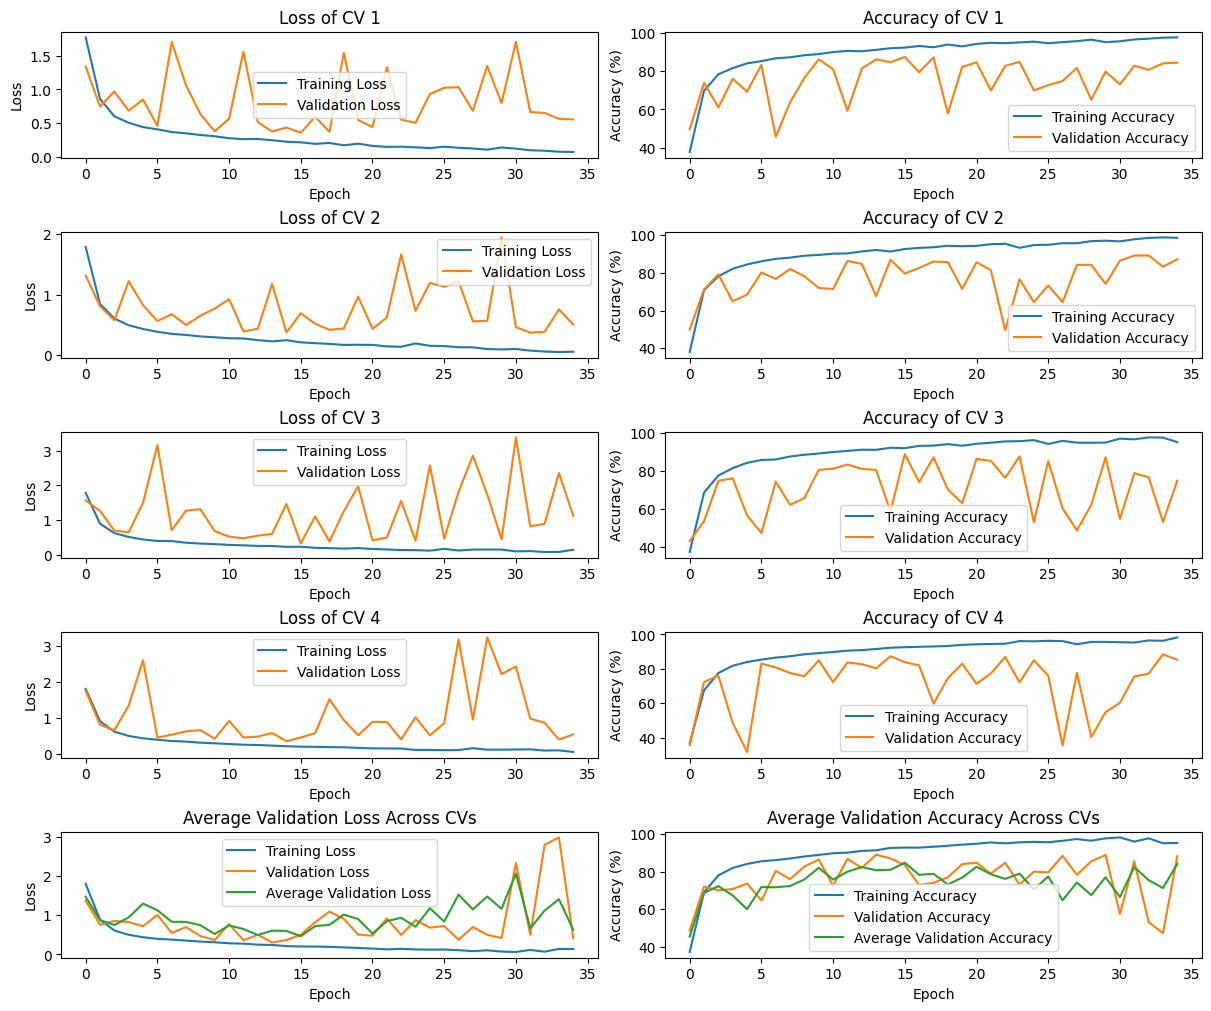

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
num_epochs = 35
num_cv = 5
decision_step = 7

cross_validate(model1, device, optimizer1, optimizer_params1, num_epochs, num_cv, decision_step)

----------[CV #1]-------------------------


Epoch 1/35, Train Loss: 1.1539, Train Acc: 57.45%, Val Loss: 13.2925, Val Acc: 21.25%


Epoch 2/35, Train Loss: 0.4788, Train Acc: 82.77%, Val Loss: 3.1597, Val Acc: 56.06%


Epoch 3/35, Train Loss: 0.3732, Train Acc: 86.39%, Val Loss: 0.4258, Val Acc: 85.81%


Epoch 4/35, Train Loss: 0.3197, Train Acc: 88.32%, Val Loss: 0.3023, Val Acc: 89.27%


Epoch 5/35, Train Loss: 0.2846, Train Acc: 89.69%, Val Loss: 0.2972, Val Acc: 89.34%


Epoch 6/35, Train Loss: 0.2632, Train Acc: 90.28%, Val Loss: 0.2742, Val Acc: 90.59%


Epoch 7/35, Train Loss: 0.2869, Train Acc: 89.81%, Val Loss: 0.3346, Val Acc: 87.88%


Epoch 8/35, Train Loss: 0.2352, Train Acc: 91.43%, Val Loss: 0.2398, Val Acc: 91.41%


Epoch 9/35, Train Loss: 0.1934, Train Acc: 92.84%, Val Loss: 0.2535, Val Acc: 91.15%


Epoch 10/35, Train Loss: 0.1842, Train Acc: 93.22%, Val Loss: 0.2540, Val Acc: 91.20%


Epoch 11/35, Train Loss: 0.1558, Train Acc: 94.29%, Val Loss: 0.2215, Val Acc: 92.14%


Epoch 12/35, Train Loss: 0.1281, Train Acc: 95.26%, Val Loss: 0.2278, Val Acc: 92.36%


Epoch 13/35, Train Loss: 0.1149, Train Acc: 95.75%, Val Loss: 0.2544, Val Acc: 92.23%


Epoch 14/35, Train Loss: 0.1125, Train Acc: 95.71%, Val Loss: 0.2537, Val Acc: 92.17%


Epoch 15/35, Train Loss: 0.1000, Train Acc: 96.23%, Val Loss: 0.3284, Val Acc: 90.72%


Epoch 16/35, Train Loss: 0.1968, Train Acc: 92.97%, Val Loss: 0.2604, Val Acc: 91.16%


Epoch 17/35, Train Loss: 0.1665, Train Acc: 93.82%, Val Loss: 0.2261, Val Acc: 92.31%


Epoch 18/35, Train Loss: 0.1311, Train Acc: 95.04%, Val Loss: 0.2263, Val Acc: 92.38%


Epoch 19/35, Train Loss: 0.1234, Train Acc: 95.38%, Val Loss: 0.2746, Val Acc: 91.27%


Epoch 20/35, Train Loss: 0.0954, Train Acc: 96.38%, Val Loss: 0.2600, Val Acc: 92.06%


Epoch 21/35, Train Loss: 0.1065, Train Acc: 96.06%, Val Loss: 0.2625, Val Acc: 91.93%


Epoch 22/35, Train Loss: 0.0832, Train Acc: 96.90%, Val Loss: 0.2643, Val Acc: 92.29%


Epoch 23/35, Train Loss: 0.0523, Train Acc: 98.06%, Val Loss: 0.3015, Val Acc: 92.12%


Epoch 24/35, Train Loss: 0.0512, Train Acc: 98.09%, Val Loss: 0.3443, Val Acc: 91.57%


Epoch 25/35, Train Loss: 0.0708, Train Acc: 97.42%, Val Loss: 0.3090, Val Acc: 92.06%


Epoch 26/35, Train Loss: 0.0521, Train Acc: 98.08%, Val Loss: 0.2797, Val Acc: 92.89%


Epoch 27/35, Train Loss: 0.0484, Train Acc: 98.14%, Val Loss: 0.3220, Val Acc: 92.21%


Epoch 28/35, Train Loss: 0.0500, Train Acc: 98.09%, Val Loss: 0.3251, Val Acc: 92.39%


Epoch 29/35, Train Loss: 0.0370, Train Acc: 98.69%, Val Loss: 0.3243, Val Acc: 92.91%


Epoch 30/35, Train Loss: 0.0265, Train Acc: 99.07%, Val Loss: 0.3641, Val Acc: 92.46%


Epoch 31/35, Train Loss: 0.0511, Train Acc: 98.14%, Val Loss: 0.3997, Val Acc: 91.73%


Epoch 32/35, Train Loss: 0.1481, Train Acc: 94.99%, Val Loss: 0.2917, Val Acc: 91.77%


Epoch 33/35, Train Loss: 0.1036, Train Acc: 96.11%, Val Loss: 0.2475, Val Acc: 92.14%


Epoch 34/35, Train Loss: 0.0593, Train Acc: 97.87%, Val Loss: 0.2704, Val Acc: 92.50%


Epoch 35/35, Train Loss: 0.0534, Train Acc: 98.14%, Val Loss: 0.3219, Val Acc: 92.06%
--------------------------------------------------------------------------------
----------[CV #2]-------------------------


Epoch 1/35, Train Loss: 1.1566, Train Acc: 57.21%, Val Loss: 26.8401, Val Acc: 16.34%


Epoch 2/35, Train Loss: 0.4592, Train Acc: 83.43%, Val Loss: 3.2910, Val Acc: 55.25%


Epoch 3/35, Train Loss: 0.3816, Train Acc: 86.18%, Val Loss: 0.4523, Val Acc: 83.91%


Epoch 4/35, Train Loss: 0.3337, Train Acc: 87.90%, Val Loss: 0.3762, Val Acc: 87.21%


Epoch 5/35, Train Loss: 0.2767, Train Acc: 89.90%, Val Loss: 0.2917, Val Acc: 89.42%


Epoch 6/35, Train Loss: 0.2528, Train Acc: 90.93%, Val Loss: 0.2677, Val Acc: 90.14%


Epoch 7/35, Train Loss: 0.2152, Train Acc: 92.07%, Val Loss: 0.2505, Val Acc: 90.92%


Epoch 8/35, Train Loss: 0.2015, Train Acc: 92.58%, Val Loss: 0.2426, Val Acc: 91.27%


Epoch 9/35, Train Loss: 0.1780, Train Acc: 93.34%, Val Loss: 0.2313, Val Acc: 91.76%


Epoch 10/35, Train Loss: 0.1606, Train Acc: 93.86%, Val Loss: 0.2323, Val Acc: 92.03%


Epoch 11/35, Train Loss: 0.1483, Train Acc: 94.39%, Val Loss: 0.2311, Val Acc: 91.93%


Epoch 12/35, Train Loss: 0.1531, Train Acc: 94.25%, Val Loss: 0.2363, Val Acc: 92.00%


Epoch 13/35, Train Loss: 0.1393, Train Acc: 94.79%, Val Loss: 0.2546, Val Acc: 91.86%


Epoch 14/35, Train Loss: 0.1300, Train Acc: 95.10%, Val Loss: 0.2572, Val Acc: 91.87%


Epoch 15/35, Train Loss: 0.1357, Train Acc: 94.95%, Val Loss: 0.2822, Val Acc: 91.24%


Epoch 16/35, Train Loss: 0.1370, Train Acc: 94.85%, Val Loss: 0.2492, Val Acc: 91.75%


Epoch 17/35, Train Loss: 0.1035, Train Acc: 96.09%, Val Loss: 0.2488, Val Acc: 92.39%


Epoch 18/35, Train Loss: 0.0870, Train Acc: 96.87%, Val Loss: 0.2598, Val Acc: 92.29%


Epoch 19/35, Train Loss: 0.0749, Train Acc: 97.23%, Val Loss: 0.2709, Val Acc: 92.29%


Epoch 20/35, Train Loss: 0.0547, Train Acc: 98.01%, Val Loss: 0.2921, Val Acc: 92.55%


Epoch 21/35, Train Loss: 0.0774, Train Acc: 97.16%, Val Loss: 0.3115, Val Acc: 91.77%


Epoch 22/35, Train Loss: 0.0697, Train Acc: 97.35%, Val Loss: 0.3081, Val Acc: 91.35%


Epoch 23/35, Train Loss: 0.0897, Train Acc: 96.61%, Val Loss: 0.2878, Val Acc: 92.07%


Epoch 24/35, Train Loss: 0.0842, Train Acc: 96.81%, Val Loss: 0.3546, Val Acc: 90.77%


Epoch 25/35, Train Loss: 0.1116, Train Acc: 95.96%, Val Loss: 0.2778, Val Acc: 92.04%


Epoch 26/35, Train Loss: 0.0780, Train Acc: 97.11%, Val Loss: 0.2700, Val Acc: 92.17%


Epoch 27/35, Train Loss: 0.0806, Train Acc: 97.11%, Val Loss: 0.3229, Val Acc: 91.91%


Epoch 28/35, Train Loss: 0.0700, Train Acc: 97.44%, Val Loss: 0.3048, Val Acc: 92.24%


Epoch 29/35, Train Loss: 0.0667, Train Acc: 97.53%, Val Loss: 0.3091, Val Acc: 91.78%


Epoch 30/35, Train Loss: 0.0427, Train Acc: 98.46%, Val Loss: 0.3140, Val Acc: 92.32%


Epoch 31/35, Train Loss: 0.0418, Train Acc: 98.50%, Val Loss: 0.3205, Val Acc: 92.33%


Epoch 32/35, Train Loss: 0.0696, Train Acc: 97.66%, Val Loss: 0.3465, Val Acc: 91.52%


Epoch 33/35, Train Loss: 0.0495, Train Acc: 98.23%, Val Loss: 0.3345, Val Acc: 91.91%


Epoch 34/35, Train Loss: 0.0554, Train Acc: 98.04%, Val Loss: 0.3654, Val Acc: 91.95%


Epoch 35/35, Train Loss: 0.0735, Train Acc: 97.33%, Val Loss: 0.3237, Val Acc: 91.98%
--------------------------------------------------------------------------------
----------[CV #3]-------------------------


Epoch 1/35, Train Loss: 1.1831, Train Acc: 55.70%, Val Loss: 12.2578, Val Acc: 27.66%


Epoch 2/35, Train Loss: 0.4660, Train Acc: 83.27%, Val Loss: 9.4884, Val Acc: 34.06%


Epoch 3/35, Train Loss: 0.4361, Train Acc: 84.52%, Val Loss: 0.6858, Val Acc: 78.81%


Epoch 4/35, Train Loss: 0.3468, Train Acc: 87.42%, Val Loss: 0.3269, Val Acc: 88.26%


Epoch 5/35, Train Loss: 0.2775, Train Acc: 89.80%, Val Loss: 0.2669, Val Acc: 90.31%


Epoch 6/35, Train Loss: 0.3118, Train Acc: 88.87%, Val Loss: 0.2764, Val Acc: 89.89%


Epoch 7/35, Train Loss: 0.2560, Train Acc: 90.68%, Val Loss: 0.2477, Val Acc: 90.79%


Epoch 8/35, Train Loss: 0.2144, Train Acc: 92.27%, Val Loss: 0.2235, Val Acc: 92.09%


Epoch 9/35, Train Loss: 0.1880, Train Acc: 93.09%, Val Loss: 0.2230, Val Acc: 92.12%


Epoch 10/35, Train Loss: 0.1959, Train Acc: 92.87%, Val Loss: 0.2605, Val Acc: 90.89%


Epoch 11/35, Train Loss: 0.1651, Train Acc: 94.05%, Val Loss: 0.2128, Val Acc: 92.54%


Epoch 12/35, Train Loss: 0.1529, Train Acc: 94.38%, Val Loss: 0.2223, Val Acc: 92.18%


Epoch 13/35, Train Loss: 0.1280, Train Acc: 95.37%, Val Loss: 0.2267, Val Acc: 92.31%


Epoch 14/35, Train Loss: 0.1083, Train Acc: 96.02%, Val Loss: 0.2443, Val Acc: 92.18%


Epoch 15/35, Train Loss: 0.0914, Train Acc: 96.58%, Val Loss: 0.2525, Val Acc: 92.61%


Epoch 16/35, Train Loss: 0.1121, Train Acc: 95.92%, Val Loss: 0.2514, Val Acc: 92.14%


Epoch 17/35, Train Loss: 0.0841, Train Acc: 96.87%, Val Loss: 0.2509, Val Acc: 92.56%


Epoch 18/35, Train Loss: 0.0682, Train Acc: 97.40%, Val Loss: 0.2930, Val Acc: 92.32%


Epoch 19/35, Train Loss: 0.0600, Train Acc: 97.74%, Val Loss: 0.2976, Val Acc: 92.37%


Epoch 20/35, Train Loss: 0.1581, Train Acc: 94.55%, Val Loss: 0.2465, Val Acc: 92.09%


Epoch 21/35, Train Loss: 0.1269, Train Acc: 95.19%, Val Loss: 0.2382, Val Acc: 92.46%


Epoch 22/35, Train Loss: 0.1165, Train Acc: 95.64%, Val Loss: 0.2580, Val Acc: 91.75%


Epoch 23/35, Train Loss: 0.0761, Train Acc: 97.23%, Val Loss: 0.2554, Val Acc: 92.91%


Epoch 24/35, Train Loss: 0.0499, Train Acc: 98.16%, Val Loss: 0.3013, Val Acc: 92.66%


Epoch 25/35, Train Loss: 0.0965, Train Acc: 96.49%, Val Loss: 0.2746, Val Acc: 92.24%


Epoch 26/35, Train Loss: 0.0732, Train Acc: 97.25%, Val Loss: 0.2856, Val Acc: 92.17%


Epoch 27/35, Train Loss: 0.0446, Train Acc: 98.44%, Val Loss: 0.3087, Val Acc: 92.23%


Epoch 28/35, Train Loss: 0.0494, Train Acc: 98.22%, Val Loss: 0.3262, Val Acc: 92.32%


Epoch 29/35, Train Loss: 0.1166, Train Acc: 96.15%, Val Loss: 0.2962, Val Acc: 91.81%


Epoch 30/35, Train Loss: 0.1361, Train Acc: 95.03%, Val Loss: 0.2791, Val Acc: 91.28%


Epoch 31/35, Train Loss: 0.0895, Train Acc: 96.70%, Val Loss: 0.2427, Val Acc: 92.49%


Epoch 32/35, Train Loss: 0.0591, Train Acc: 97.84%, Val Loss: 0.2808, Val Acc: 92.67%


Epoch 33/35, Train Loss: 0.0493, Train Acc: 98.14%, Val Loss: 0.3144, Val Acc: 92.90%


Epoch 34/35, Train Loss: 0.0449, Train Acc: 98.33%, Val Loss: 0.3317, Val Acc: 92.53%


Epoch 35/35, Train Loss: 0.0288, Train Acc: 98.99%, Val Loss: 0.3512, Val Acc: 92.75%
--------------------------------------------------------------------------------
----------[CV #4]-------------------------


Epoch 1/35, Train Loss: 1.1602, Train Acc: 56.71%, Val Loss: 24.6834, Val Acc: 9.81%


Epoch 2/35, Train Loss: 0.5115, Train Acc: 81.60%, Val Loss: 1.4528, Val Acc: 60.28%


Epoch 3/35, Train Loss: 0.3677, Train Acc: 86.66%, Val Loss: 0.4542, Val Acc: 85.25%


Epoch 4/35, Train Loss: 0.3388, Train Acc: 87.73%, Val Loss: 0.4300, Val Acc: 84.99%


Epoch 5/35, Train Loss: 0.2660, Train Acc: 90.24%, Val Loss: 0.2972, Val Acc: 89.54%


Epoch 6/35, Train Loss: 0.2319, Train Acc: 91.47%, Val Loss: 0.2576, Val Acc: 90.68%


Epoch 7/35, Train Loss: 0.2007, Train Acc: 92.59%, Val Loss: 0.2354, Val Acc: 91.83%


Epoch 8/35, Train Loss: 0.1747, Train Acc: 93.60%, Val Loss: 0.2511, Val Acc: 91.07%


Epoch 9/35, Train Loss: 0.2286, Train Acc: 91.68%, Val Loss: 0.2709, Val Acc: 90.53%


Epoch 10/35, Train Loss: 0.2225, Train Acc: 91.85%, Val Loss: 0.2615, Val Acc: 90.77%


Epoch 11/35, Train Loss: 0.1820, Train Acc: 93.26%, Val Loss: 0.2264, Val Acc: 91.89%


Epoch 12/35, Train Loss: 0.1538, Train Acc: 94.36%, Val Loss: 0.2267, Val Acc: 92.13%


Epoch 13/35, Train Loss: 0.1300, Train Acc: 95.14%, Val Loss: 0.2594, Val Acc: 91.87%


Epoch 14/35, Train Loss: 0.1238, Train Acc: 95.43%, Val Loss: 0.2311, Val Acc: 92.46%


Epoch 15/35, Train Loss: 0.0922, Train Acc: 96.61%, Val Loss: 0.2533, Val Acc: 92.56%


Epoch 16/35, Train Loss: 0.0994, Train Acc: 96.29%, Val Loss: 0.2807, Val Acc: 91.56%


Epoch 17/35, Train Loss: 0.1272, Train Acc: 95.35%, Val Loss: 0.2548, Val Acc: 91.53%


Epoch 18/35, Train Loss: 0.0901, Train Acc: 96.66%, Val Loss: 0.2787, Val Acc: 92.11%


Epoch 19/35, Train Loss: 0.0805, Train Acc: 97.03%, Val Loss: 0.2787, Val Acc: 92.16%


Epoch 20/35, Train Loss: 0.0621, Train Acc: 97.65%, Val Loss: 0.3009, Val Acc: 91.93%


Epoch 21/35, Train Loss: 0.0515, Train Acc: 98.13%, Val Loss: 0.3277, Val Acc: 91.93%


Epoch 22/35, Train Loss: 0.0463, Train Acc: 98.30%, Val Loss: 0.3463, Val Acc: 91.91%


Epoch 23/35, Train Loss: 0.0462, Train Acc: 98.35%, Val Loss: 0.3680, Val Acc: 91.87%


Epoch 24/35, Train Loss: 0.0395, Train Acc: 98.59%, Val Loss: 0.3627, Val Acc: 92.05%


Epoch 25/35, Train Loss: 0.1232, Train Acc: 95.73%, Val Loss: 0.2990, Val Acc: 91.57%


Epoch 26/35, Train Loss: 0.1059, Train Acc: 96.12%, Val Loss: 0.2686, Val Acc: 91.95%


Epoch 27/35, Train Loss: 0.0749, Train Acc: 97.21%, Val Loss: 0.2814, Val Acc: 92.04%


Epoch 28/35, Train Loss: 0.0595, Train Acc: 97.79%, Val Loss: 0.3275, Val Acc: 91.63%


Epoch 29/35, Train Loss: 0.0682, Train Acc: 97.50%, Val Loss: 0.2976, Val Acc: 92.38%


Epoch 30/35, Train Loss: 0.0501, Train Acc: 98.12%, Val Loss: 0.3247, Val Acc: 92.02%


Epoch 31/35, Train Loss: 0.0328, Train Acc: 98.84%, Val Loss: 0.3979, Val Acc: 91.96%


Epoch 32/35, Train Loss: 0.1089, Train Acc: 96.25%, Val Loss: 0.3425, Val Acc: 91.01%


Epoch 33/35, Train Loss: 0.0952, Train Acc: 96.49%, Val Loss: 0.2699, Val Acc: 92.19%


Epoch 34/35, Train Loss: 0.0725, Train Acc: 97.38%, Val Loss: 0.2763, Val Acc: 92.29%


Epoch 35/35, Train Loss: 0.0438, Train Acc: 98.40%, Val Loss: 0.2986, Val Acc: 92.49%
--------------------------------------------------------------------------------
----------[CV #5]-------------------------


Epoch 1/35, Train Loss: 1.1984, Train Acc: 55.30%, Val Loss: 7.4989, Val Acc: 34.67%


Epoch 2/35, Train Loss: 0.4532, Train Acc: 83.81%, Val Loss: 2.3458, Val Acc: 62.49%


Epoch 3/35, Train Loss: 0.3648, Train Acc: 86.68%, Val Loss: 0.4397, Val Acc: 85.68%


Epoch 4/35, Train Loss: 0.3235, Train Acc: 88.17%, Val Loss: 0.3253, Val Acc: 88.91%


Epoch 5/35, Train Loss: 0.2729, Train Acc: 89.86%, Val Loss: 0.2826, Val Acc: 90.12%


Epoch 6/35, Train Loss: 0.2234, Train Acc: 91.75%, Val Loss: 0.2529, Val Acc: 91.29%


Epoch 7/35, Train Loss: 0.2102, Train Acc: 92.25%, Val Loss: 0.2504, Val Acc: 91.25%


Epoch 8/35, Train Loss: 0.1787, Train Acc: 93.53%, Val Loss: 0.2309, Val Acc: 91.85%


Epoch 9/35, Train Loss: 0.1748, Train Acc: 93.63%, Val Loss: 0.2336, Val Acc: 91.83%


Epoch 10/35, Train Loss: 0.1705, Train Acc: 93.61%, Val Loss: 0.2279, Val Acc: 91.99%


Epoch 11/35, Train Loss: 0.1394, Train Acc: 94.72%, Val Loss: 0.2488, Val Acc: 91.27%


Epoch 12/35, Train Loss: 0.1313, Train Acc: 95.18%, Val Loss: 0.2494, Val Acc: 91.62%


Epoch 13/35, Train Loss: 0.1053, Train Acc: 96.11%, Val Loss: 0.2547, Val Acc: 92.06%


Epoch 14/35, Train Loss: 0.1063, Train Acc: 96.11%, Val Loss: 0.2629, Val Acc: 92.36%


Epoch 15/35, Train Loss: 0.1195, Train Acc: 95.60%, Val Loss: 0.2612, Val Acc: 91.96%


Epoch 16/35, Train Loss: 0.0940, Train Acc: 96.50%, Val Loss: 0.2621, Val Acc: 92.29%


Epoch 17/35, Train Loss: 0.0701, Train Acc: 97.34%, Val Loss: 0.2805, Val Acc: 92.46%


Epoch 18/35, Train Loss: 0.1127, Train Acc: 95.88%, Val Loss: 0.2869, Val Acc: 91.43%


Epoch 19/35, Train Loss: 0.1059, Train Acc: 96.00%, Val Loss: 0.2590, Val Acc: 91.96%


Epoch 20/35, Train Loss: 0.0833, Train Acc: 96.98%, Val Loss: 0.2785, Val Acc: 91.93%


Epoch 21/35, Train Loss: 0.0837, Train Acc: 97.00%, Val Loss: 0.3094, Val Acc: 91.50%


Epoch 22/35, Train Loss: 0.0842, Train Acc: 96.96%, Val Loss: 0.3292, Val Acc: 91.41%


Epoch 23/35, Train Loss: 0.0617, Train Acc: 97.75%, Val Loss: 0.3041, Val Acc: 92.03%


Epoch 24/35, Train Loss: 0.1230, Train Acc: 95.65%, Val Loss: 0.2672, Val Acc: 91.87%


Epoch 25/35, Train Loss: 0.0990, Train Acc: 96.29%, Val Loss: 0.2587, Val Acc: 92.17%


Epoch 26/35, Train Loss: 0.0810, Train Acc: 97.00%, Val Loss: 0.2841, Val Acc: 92.37%


Epoch 27/35, Train Loss: 0.0670, Train Acc: 97.60%, Val Loss: 0.3064, Val Acc: 92.50%


Epoch 28/35, Train Loss: 0.0425, Train Acc: 98.51%, Val Loss: 0.3136, Val Acc: 92.26%


Epoch 29/35, Train Loss: 0.0865, Train Acc: 96.98%, Val Loss: 0.3162, Val Acc: 92.39%


Epoch 30/35, Train Loss: 0.0794, Train Acc: 97.11%, Val Loss: 0.2908, Val Acc: 92.20%


Epoch 31/35, Train Loss: 0.0493, Train Acc: 98.25%, Val Loss: 0.2871, Val Acc: 92.61%


Epoch 32/35, Train Loss: 0.0438, Train Acc: 98.38%, Val Loss: 0.3214, Val Acc: 92.62%


Epoch 33/35, Train Loss: 0.0276, Train Acc: 99.01%, Val Loss: 0.3375, Val Acc: 92.67%


Epoch 34/35, Train Loss: 0.0172, Train Acc: 99.42%, Val Loss: 0.3534, Val Acc: 92.86%


Epoch 35/35, Train Loss: 0.0159, Train Acc: 99.43%, Val Loss: 0.3969, Val Acc: 92.52%
--------------------------------------------------------------------------------
CV completed in  113m  57s


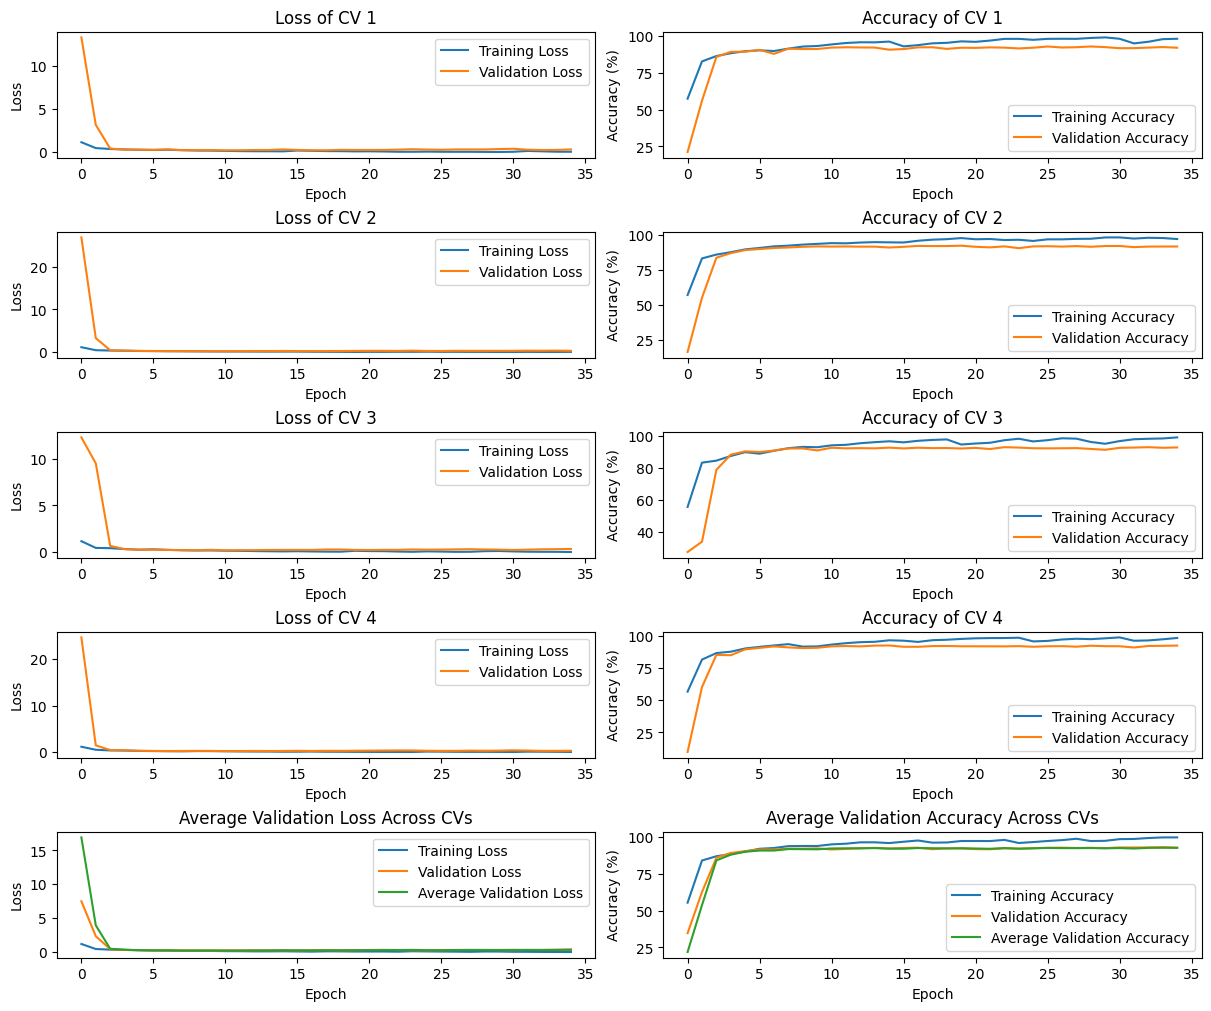

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cross_validate(model2, device, optimizer2, optimizer_params2, num_epochs, num_cv, decision_step)

----------[CV #1]-------------------------


Epoch 1/35, Train Loss: 1.1666, Train Acc: 56.30%, Val Loss: 25.8270, Val Acc: 10.10%


Epoch 2/35, Train Loss: 0.4744, Train Acc: 83.08%, Val Loss: 2.5395, Val Acc: 56.68%


Epoch 3/35, Train Loss: 0.3539, Train Acc: 87.05%, Val Loss: 1.1509, Val Acc: 74.88%


Epoch 4/35, Train Loss: 0.3487, Train Acc: 87.35%, Val Loss: 0.4333, Val Acc: 85.90%


Epoch 5/35, Train Loss: 0.2920, Train Acc: 89.31%, Val Loss: 0.3928, Val Acc: 87.29%


Epoch 6/35, Train Loss: 0.3245, Train Acc: 88.19%, Val Loss: 0.2882, Val Acc: 89.64%


Epoch 7/35, Train Loss: 0.2711, Train Acc: 90.29%, Val Loss: 0.2804, Val Acc: 90.56%


Epoch 8/35, Train Loss: 0.2643, Train Acc: 90.45%, Val Loss: 0.2770, Val Acc: 90.46%


Epoch 9/35, Train Loss: 0.2676, Train Acc: 90.12%, Val Loss: 0.2551, Val Acc: 90.92%


Epoch 10/35, Train Loss: 0.2270, Train Acc: 91.55%, Val Loss: 0.2600, Val Acc: 90.59%


Epoch 11/35, Train Loss: 0.2193, Train Acc: 92.06%, Val Loss: 0.2478, Val Acc: 91.54%


Epoch 12/35, Train Loss: 0.1884, Train Acc: 93.04%, Val Loss: 0.2220, Val Acc: 92.27%


Epoch 13/35, Train Loss: 0.1659, Train Acc: 94.00%, Val Loss: 0.2186, Val Acc: 92.61%


Epoch 14/35, Train Loss: 0.1540, Train Acc: 94.17%, Val Loss: 0.2249, Val Acc: 92.42%


Epoch 15/35, Train Loss: 0.1339, Train Acc: 95.03%, Val Loss: 0.2205, Val Acc: 93.01%


Epoch 16/35, Train Loss: 0.1427, Train Acc: 94.88%, Val Loss: 0.2335, Val Acc: 92.44%


Epoch 17/35, Train Loss: 0.1297, Train Acc: 95.17%, Val Loss: 0.2440, Val Acc: 92.18%


Epoch 18/35, Train Loss: 0.1083, Train Acc: 96.07%, Val Loss: 0.3039, Val Acc: 91.12%


Epoch 19/35, Train Loss: 0.0961, Train Acc: 96.42%, Val Loss: 0.2593, Val Acc: 92.65%


Epoch 20/35, Train Loss: 0.0790, Train Acc: 97.09%, Val Loss: 0.2641, Val Acc: 93.04%


Epoch 21/35, Train Loss: 0.0935, Train Acc: 96.53%, Val Loss: 0.2745, Val Acc: 92.50%


Epoch 22/35, Train Loss: 0.1011, Train Acc: 96.17%, Val Loss: 0.2590, Val Acc: 92.68%


Epoch 23/35, Train Loss: 0.0769, Train Acc: 97.14%, Val Loss: 0.2472, Val Acc: 93.00%


Epoch 24/35, Train Loss: 0.0586, Train Acc: 97.89%, Val Loss: 0.3014, Val Acc: 92.39%


Epoch 25/35, Train Loss: 0.0786, Train Acc: 97.15%, Val Loss: 0.2982, Val Acc: 92.33%


Epoch 26/35, Train Loss: 0.0658, Train Acc: 97.56%, Val Loss: 0.3020, Val Acc: 92.23%


Epoch 27/35, Train Loss: 0.0507, Train Acc: 98.08%, Val Loss: 0.2876, Val Acc: 93.01%


Epoch 28/35, Train Loss: 0.0397, Train Acc: 98.56%, Val Loss: 0.3588, Val Acc: 92.56%


Epoch 29/35, Train Loss: 0.0354, Train Acc: 98.73%, Val Loss: 0.3625, Val Acc: 92.72%


Epoch 30/35, Train Loss: 0.0890, Train Acc: 96.79%, Val Loss: 0.2856, Val Acc: 92.46%


Epoch 31/35, Train Loss: 0.0518, Train Acc: 98.07%, Val Loss: 0.2941, Val Acc: 91.82%


Epoch 32/35, Train Loss: 0.0546, Train Acc: 98.02%, Val Loss: 0.3240, Val Acc: 92.17%


Epoch 33/35, Train Loss: 0.0536, Train Acc: 98.06%, Val Loss: 0.3327, Val Acc: 92.48%


Epoch 34/35, Train Loss: 0.0478, Train Acc: 98.40%, Val Loss: 0.3146, Val Acc: 92.81%


Epoch 35/35, Train Loss: 0.0533, Train Acc: 98.10%, Val Loss: 0.3147, Val Acc: 92.66%
--------------------------------------------------------------------------------
----------[CV #2]-------------------------


Epoch 1/35, Train Loss: 1.2009, Train Acc: 55.72%, Val Loss: 11.0474, Val Acc: 25.03%


Epoch 2/35, Train Loss: 0.5369, Train Acc: 80.66%, Val Loss: 13.9119, Val Acc: 24.91%


Epoch 3/35, Train Loss: 0.3894, Train Acc: 85.87%, Val Loss: 1.2056, Val Acc: 71.48%


Epoch 4/35, Train Loss: 0.3266, Train Acc: 88.22%, Val Loss: 0.6908, Val Acc: 81.46%


Epoch 5/35, Train Loss: 0.3099, Train Acc: 88.96%, Val Loss: 0.5630, Val Acc: 83.16%


Epoch 6/35, Train Loss: 0.2843, Train Acc: 89.89%, Val Loss: 0.3640, Val Acc: 88.53%


Epoch 7/35, Train Loss: 0.2573, Train Acc: 90.76%, Val Loss: 0.2964, Val Acc: 89.93%


Epoch 8/35, Train Loss: 0.2217, Train Acc: 91.90%, Val Loss: 0.2438, Val Acc: 91.41%


Epoch 9/35, Train Loss: 0.2039, Train Acc: 92.59%, Val Loss: 0.2590, Val Acc: 91.21%


Epoch 10/35, Train Loss: 0.1731, Train Acc: 93.64%, Val Loss: 0.2386, Val Acc: 91.60%


Epoch 11/35, Train Loss: 0.1587, Train Acc: 94.12%, Val Loss: 0.2331, Val Acc: 91.99%


Epoch 12/35, Train Loss: 0.1521, Train Acc: 94.50%, Val Loss: 0.2531, Val Acc: 91.81%


Epoch 13/35, Train Loss: 0.1377, Train Acc: 95.09%, Val Loss: 0.2425, Val Acc: 92.08%


Epoch 14/35, Train Loss: 0.1361, Train Acc: 94.86%, Val Loss: 0.2370, Val Acc: 92.34%


Epoch 15/35, Train Loss: 0.1214, Train Acc: 95.70%, Val Loss: 0.2580, Val Acc: 91.77%


Epoch 16/35, Train Loss: 0.1013, Train Acc: 96.33%, Val Loss: 0.2494, Val Acc: 92.38%


Epoch 17/35, Train Loss: 0.0809, Train Acc: 97.04%, Val Loss: 0.2755, Val Acc: 92.27%


Epoch 18/35, Train Loss: 0.0618, Train Acc: 97.70%, Val Loss: 0.3009, Val Acc: 92.49%


Epoch 19/35, Train Loss: 0.1171, Train Acc: 95.88%, Val Loss: 0.2757, Val Acc: 91.64%


Epoch 20/35, Train Loss: 0.1177, Train Acc: 95.60%, Val Loss: 0.2599, Val Acc: 91.92%


Epoch 21/35, Train Loss: 0.1430, Train Acc: 95.02%, Val Loss: 0.2727, Val Acc: 91.30%


Epoch 22/35, Train Loss: 0.1070, Train Acc: 96.02%, Val Loss: 0.2704, Val Acc: 91.88%


Epoch 23/35, Train Loss: 0.0960, Train Acc: 96.60%, Val Loss: 0.2774, Val Acc: 91.98%


Epoch 24/35, Train Loss: 0.1086, Train Acc: 96.14%, Val Loss: 0.2880, Val Acc: 91.74%


Epoch 25/35, Train Loss: 0.0871, Train Acc: 96.80%, Val Loss: 0.2775, Val Acc: 92.18%


Epoch 26/35, Train Loss: 0.0829, Train Acc: 97.01%, Val Loss: 0.2916, Val Acc: 91.98%


Epoch 27/35, Train Loss: 0.0581, Train Acc: 97.84%, Val Loss: 0.3088, Val Acc: 92.31%


Epoch 28/35, Train Loss: 0.0797, Train Acc: 97.15%, Val Loss: 0.3474, Val Acc: 91.31%


Epoch 29/35, Train Loss: 0.0720, Train Acc: 97.29%, Val Loss: 0.3119, Val Acc: 92.07%


Epoch 30/35, Train Loss: 0.0467, Train Acc: 98.28%, Val Loss: 0.3378, Val Acc: 91.92%


Epoch 31/35, Train Loss: 0.0561, Train Acc: 97.99%, Val Loss: 0.3233, Val Acc: 92.14%


Epoch 32/35, Train Loss: 0.0486, Train Acc: 98.25%, Val Loss: 0.3381, Val Acc: 92.39%


Epoch 33/35, Train Loss: 0.0294, Train Acc: 98.96%, Val Loss: 0.3487, Val Acc: 92.58%


Epoch 34/35, Train Loss: 0.0358, Train Acc: 98.70%, Val Loss: 0.4023, Val Acc: 92.47%


Epoch 35/35, Train Loss: 0.0331, Train Acc: 98.84%, Val Loss: 0.3835, Val Acc: 92.38%
--------------------------------------------------------------------------------
----------[CV #3]-------------------------


Epoch 1/35, Train Loss: 1.1930, Train Acc: 55.28%, Val Loss: 3.0816, Val Acc: 37.58%


Epoch 2/35, Train Loss: 0.4746, Train Acc: 82.86%, Val Loss: 3.9047, Val Acc: 45.86%


Epoch 3/35, Train Loss: 0.3855, Train Acc: 86.17%, Val Loss: 0.8456, Val Acc: 78.27%


Epoch 4/35, Train Loss: 0.3114, Train Acc: 88.68%, Val Loss: 0.3477, Val Acc: 88.59%


Epoch 5/35, Train Loss: 0.2797, Train Acc: 89.90%, Val Loss: 0.3093, Val Acc: 89.72%


Epoch 6/35, Train Loss: 0.2432, Train Acc: 91.09%, Val Loss: 0.2641, Val Acc: 90.72%


Epoch 7/35, Train Loss: 0.2202, Train Acc: 91.96%, Val Loss: 0.2611, Val Acc: 91.24%


Epoch 8/35, Train Loss: 0.2067, Train Acc: 92.42%, Val Loss: 0.2432, Val Acc: 91.64%


Epoch 9/35, Train Loss: 0.2212, Train Acc: 91.96%, Val Loss: 0.2527, Val Acc: 91.14%


Epoch 10/35, Train Loss: 0.2032, Train Acc: 92.77%, Val Loss: 0.2602, Val Acc: 91.41%


Epoch 11/35, Train Loss: 0.2094, Train Acc: 92.47%, Val Loss: 0.2519, Val Acc: 91.29%


Epoch 12/35, Train Loss: 0.1886, Train Acc: 93.19%, Val Loss: 0.2576, Val Acc: 91.23%


Epoch 13/35, Train Loss: 0.1699, Train Acc: 93.73%, Val Loss: 0.2336, Val Acc: 91.88%


Epoch 14/35, Train Loss: 0.1633, Train Acc: 94.02%, Val Loss: 0.2325, Val Acc: 92.09%


Epoch 15/35, Train Loss: 0.1407, Train Acc: 94.84%, Val Loss: 0.2282, Val Acc: 92.34%


Epoch 16/35, Train Loss: 0.1167, Train Acc: 95.79%, Val Loss: 0.2302, Val Acc: 92.46%


Epoch 17/35, Train Loss: 0.0956, Train Acc: 96.46%, Val Loss: 0.2357, Val Acc: 92.87%


Epoch 18/35, Train Loss: 0.1003, Train Acc: 96.30%, Val Loss: 0.2708, Val Acc: 91.99%


Epoch 19/35, Train Loss: 0.0785, Train Acc: 97.13%, Val Loss: 0.2754, Val Acc: 92.20%


Epoch 20/35, Train Loss: 0.0773, Train Acc: 97.17%, Val Loss: 0.2774, Val Acc: 92.67%


Epoch 21/35, Train Loss: 0.0864, Train Acc: 96.90%, Val Loss: 0.2844, Val Acc: 92.09%


Epoch 22/35, Train Loss: 0.0857, Train Acc: 96.91%, Val Loss: 0.2780, Val Acc: 92.39%


Epoch 23/35, Train Loss: 0.0673, Train Acc: 97.48%, Val Loss: 0.2996, Val Acc: 91.82%


Epoch 24/35, Train Loss: 0.0475, Train Acc: 98.25%, Val Loss: 0.3200, Val Acc: 92.14%


Epoch 25/35, Train Loss: 0.0627, Train Acc: 97.68%, Val Loss: 0.3307, Val Acc: 92.07%


Epoch 26/35, Train Loss: 0.0577, Train Acc: 97.88%, Val Loss: 0.3062, Val Acc: 92.30%


Epoch 27/35, Train Loss: 0.0408, Train Acc: 98.53%, Val Loss: 0.3156, Val Acc: 92.43%


Epoch 28/35, Train Loss: 0.0318, Train Acc: 98.81%, Val Loss: 0.3665, Val Acc: 92.48%


Epoch 29/35, Train Loss: 0.0313, Train Acc: 98.89%, Val Loss: 0.4084, Val Acc: 92.18%


Epoch 30/35, Train Loss: 0.0459, Train Acc: 98.40%, Val Loss: 0.3681, Val Acc: 92.01%


Epoch 31/35, Train Loss: 0.0409, Train Acc: 98.44%, Val Loss: 0.3913, Val Acc: 91.34%


Epoch 32/35, Train Loss: 0.0592, Train Acc: 97.80%, Val Loss: 0.3214, Val Acc: 92.14%


Epoch 33/35, Train Loss: 0.0358, Train Acc: 98.67%, Val Loss: 0.3418, Val Acc: 92.20%


Epoch 34/35, Train Loss: 0.0499, Train Acc: 98.42%, Val Loss: 0.3421, Val Acc: 92.09%


Epoch 35/35, Train Loss: 0.0319, Train Acc: 98.91%, Val Loss: 0.3981, Val Acc: 91.71%
--------------------------------------------------------------------------------
----------[CV #4]-------------------------


Epoch 1/35, Train Loss: 1.1845, Train Acc: 55.66%, Val Loss: 9.3731, Val Acc: 24.39%


Epoch 2/35, Train Loss: 0.4739, Train Acc: 83.02%, Val Loss: 1.8565, Val Acc: 65.11%


Epoch 3/35, Train Loss: 0.4116, Train Acc: 85.39%, Val Loss: 0.6285, Val Acc: 81.72%


Epoch 4/35, Train Loss: 0.3383, Train Acc: 87.77%, Val Loss: 0.3692, Val Acc: 86.79%


Epoch 5/35, Train Loss: 0.2868, Train Acc: 89.33%, Val Loss: 0.3091, Val Acc: 89.10%


Epoch 6/35, Train Loss: 0.2851, Train Acc: 89.94%, Val Loss: 0.3476, Val Acc: 87.92%


Epoch 7/35, Train Loss: 0.2677, Train Acc: 90.40%, Val Loss: 0.2814, Val Acc: 89.92%


Epoch 8/35, Train Loss: 0.2698, Train Acc: 90.41%, Val Loss: 0.2761, Val Acc: 89.93%


Epoch 9/35, Train Loss: 0.2273, Train Acc: 91.69%, Val Loss: 0.2522, Val Acc: 91.03%


Epoch 10/35, Train Loss: 0.1969, Train Acc: 92.93%, Val Loss: 0.2448, Val Acc: 91.28%


Epoch 11/35, Train Loss: 0.1713, Train Acc: 93.74%, Val Loss: 0.2531, Val Acc: 91.51%


Epoch 12/35, Train Loss: 0.1515, Train Acc: 94.41%, Val Loss: 0.2392, Val Acc: 91.82%


Epoch 13/35, Train Loss: 0.1558, Train Acc: 94.37%, Val Loss: 0.2676, Val Acc: 91.29%


Epoch 14/35, Train Loss: 0.1419, Train Acc: 94.92%, Val Loss: 0.2492, Val Acc: 91.88%


Epoch 15/35, Train Loss: 0.1211, Train Acc: 95.44%, Val Loss: 0.2548, Val Acc: 92.06%


Epoch 16/35, Train Loss: 0.1260, Train Acc: 95.46%, Val Loss: 0.2677, Val Acc: 91.60%


Epoch 17/35, Train Loss: 0.1298, Train Acc: 95.23%, Val Loss: 0.2830, Val Acc: 91.34%


Epoch 18/35, Train Loss: 0.1046, Train Acc: 96.15%, Val Loss: 0.2815, Val Acc: 91.76%


Epoch 19/35, Train Loss: 0.1011, Train Acc: 96.39%, Val Loss: 0.2868, Val Acc: 91.58%


Epoch 20/35, Train Loss: 0.1115, Train Acc: 95.98%, Val Loss: 0.2876, Val Acc: 91.66%


Epoch 21/35, Train Loss: 0.1165, Train Acc: 95.71%, Val Loss: 0.3185, Val Acc: 90.70%


Epoch 22/35, Train Loss: 0.1135, Train Acc: 95.87%, Val Loss: 0.2983, Val Acc: 91.56%


Epoch 23/35, Train Loss: 0.1105, Train Acc: 96.05%, Val Loss: 0.2814, Val Acc: 91.66%


Epoch 24/35, Train Loss: 0.0966, Train Acc: 96.49%, Val Loss: 0.2689, Val Acc: 91.89%


Epoch 25/35, Train Loss: 0.1064, Train Acc: 96.15%, Val Loss: 0.2990, Val Acc: 91.83%


Epoch 26/35, Train Loss: 0.0940, Train Acc: 96.45%, Val Loss: 0.2895, Val Acc: 91.82%


Epoch 27/35, Train Loss: 0.0697, Train Acc: 97.43%, Val Loss: 0.3105, Val Acc: 91.97%


Epoch 28/35, Train Loss: 0.0589, Train Acc: 97.80%, Val Loss: 0.3364, Val Acc: 92.02%


Epoch 29/35, Train Loss: 0.0539, Train Acc: 98.02%, Val Loss: 0.3433, Val Acc: 92.07%


Epoch 30/35, Train Loss: 0.0455, Train Acc: 98.39%, Val Loss: 0.3659, Val Acc: 91.84%


Epoch 31/35, Train Loss: 0.0703, Train Acc: 97.49%, Val Loss: 0.3523, Val Acc: 91.68%


Epoch 32/35, Train Loss: 0.0688, Train Acc: 97.49%, Val Loss: 0.3067, Val Acc: 92.17%


Epoch 33/35, Train Loss: 0.0517, Train Acc: 98.10%, Val Loss: 0.3362, Val Acc: 91.62%


Epoch 34/35, Train Loss: 0.0669, Train Acc: 97.52%, Val Loss: 0.3377, Val Acc: 91.78%


Epoch 35/35, Train Loss: 0.0502, Train Acc: 98.16%, Val Loss: 0.3235, Val Acc: 92.01%
--------------------------------------------------------------------------------
----------[CV #5]-------------------------


Epoch 1/35, Train Loss: 1.1557, Train Acc: 58.01%, Val Loss: 16.2930, Val Acc: 23.88%


Epoch 2/35, Train Loss: 0.4810, Train Acc: 82.73%, Val Loss: 1.8049, Val Acc: 60.08%


Epoch 3/35, Train Loss: 0.3885, Train Acc: 85.94%, Val Loss: 0.4686, Val Acc: 84.74%


Epoch 4/35, Train Loss: 0.3238, Train Acc: 88.38%, Val Loss: 0.3607, Val Acc: 87.87%


Epoch 5/35, Train Loss: 0.2994, Train Acc: 89.26%, Val Loss: 0.3217, Val Acc: 89.13%


Epoch 6/35, Train Loss: 0.2560, Train Acc: 90.79%, Val Loss: 0.2854, Val Acc: 90.12%


Epoch 7/35, Train Loss: 0.2372, Train Acc: 91.48%, Val Loss: 0.2829, Val Acc: 90.02%


Epoch 8/35, Train Loss: 0.2005, Train Acc: 92.64%, Val Loss: 0.2493, Val Acc: 91.37%


Epoch 9/35, Train Loss: 0.1992, Train Acc: 92.76%, Val Loss: 0.2624, Val Acc: 91.17%


Epoch 10/35, Train Loss: 0.1851, Train Acc: 93.27%, Val Loss: 0.2458, Val Acc: 91.38%


Epoch 11/35, Train Loss: 0.1747, Train Acc: 93.48%, Val Loss: 0.2362, Val Acc: 92.04%


Epoch 12/35, Train Loss: 0.1475, Train Acc: 94.60%, Val Loss: 0.2297, Val Acc: 92.27%


Epoch 13/35, Train Loss: 0.1613, Train Acc: 94.06%, Val Loss: 0.2424, Val Acc: 91.63%


Epoch 14/35, Train Loss: 0.1508, Train Acc: 94.37%, Val Loss: 0.2313, Val Acc: 92.19%


Epoch 15/35, Train Loss: 0.1505, Train Acc: 94.49%, Val Loss: 0.2400, Val Acc: 92.04%


Epoch 16/35, Train Loss: 0.1181, Train Acc: 95.60%, Val Loss: 0.2426, Val Acc: 92.16%


Epoch 17/35, Train Loss: 0.1055, Train Acc: 96.08%, Val Loss: 0.2651, Val Acc: 91.94%


Epoch 18/35, Train Loss: 0.0854, Train Acc: 96.96%, Val Loss: 0.2794, Val Acc: 92.42%


Epoch 19/35, Train Loss: 0.0652, Train Acc: 97.65%, Val Loss: 0.3236, Val Acc: 92.04%


Epoch 20/35, Train Loss: 0.1155, Train Acc: 95.92%, Val Loss: 0.2672, Val Acc: 92.23%


Epoch 21/35, Train Loss: 0.0934, Train Acc: 96.57%, Val Loss: 0.2775, Val Acc: 92.27%


Epoch 22/35, Train Loss: 0.0948, Train Acc: 96.55%, Val Loss: 0.2853, Val Acc: 91.94%


Epoch 23/35, Train Loss: 0.0777, Train Acc: 97.20%, Val Loss: 0.3038, Val Acc: 91.98%


Epoch 24/35, Train Loss: 0.0504, Train Acc: 98.20%, Val Loss: 0.3299, Val Acc: 92.39%


Epoch 25/35, Train Loss: 0.0787, Train Acc: 97.17%, Val Loss: 0.3223, Val Acc: 92.04%


Epoch 26/35, Train Loss: 0.0795, Train Acc: 97.06%, Val Loss: 0.3159, Val Acc: 91.75%


Epoch 27/35, Train Loss: 0.0707, Train Acc: 97.38%, Val Loss: 0.3170, Val Acc: 91.97%


Epoch 28/35, Train Loss: 0.0837, Train Acc: 97.02%, Val Loss: 0.3043, Val Acc: 91.92%


Epoch 29/35, Train Loss: 0.0587, Train Acc: 97.84%, Val Loss: 0.3224, Val Acc: 92.42%


Epoch 30/35, Train Loss: 0.0438, Train Acc: 98.45%, Val Loss: 0.3357, Val Acc: 92.32%


Epoch 31/35, Train Loss: 0.0377, Train Acc: 98.67%, Val Loss: 0.3785, Val Acc: 91.92%


Epoch 32/35, Train Loss: 0.0522, Train Acc: 98.22%, Val Loss: 0.3678, Val Acc: 92.04%


Epoch 33/35, Train Loss: 0.0379, Train Acc: 98.66%, Val Loss: 0.3987, Val Acc: 92.19%


Epoch 34/35, Train Loss: 0.0484, Train Acc: 98.21%, Val Loss: 0.3786, Val Acc: 92.33%


Epoch 35/35, Train Loss: 0.0652, Train Acc: 97.72%, Val Loss: 0.3528, Val Acc: 92.13%
--------------------------------------------------------------------------------
CV completed in  112m  32s


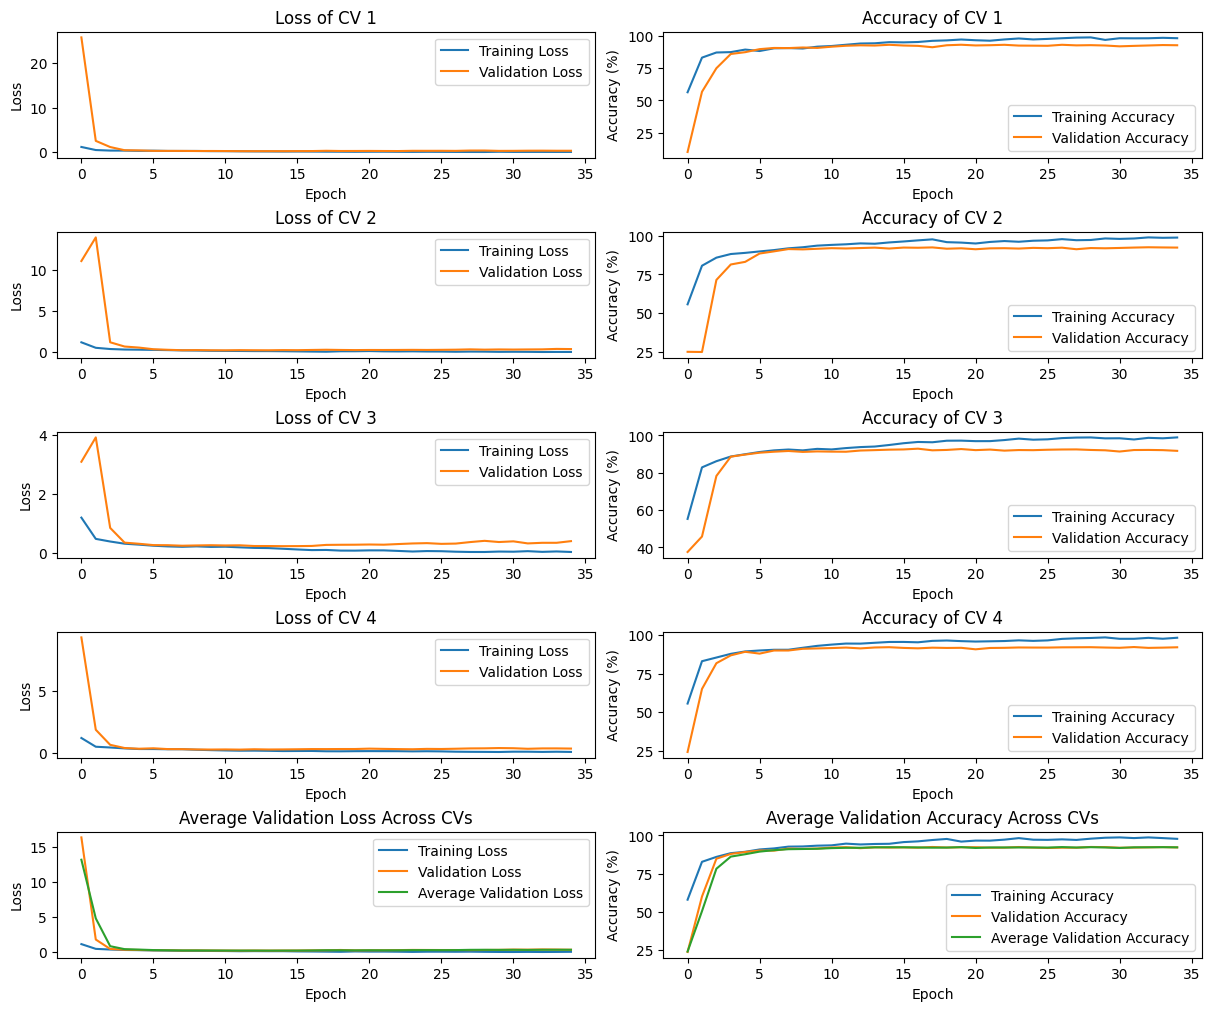

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cross_validate(model3, device, optimizer3, optimizer_params3, num_epochs, num_cv, decision_step)

## Evaluation

In [ ]:
model_dir = Path('content/models')
for m in model_dir.glob(f'*.pt'):
    loaded_model = model1.load_state_dict(torch.load(m, map_location=device, weights_only=True))
    print(f'Testing {m.name}')
    test(loaded_model, device, test_loader, [], [])

# Visualizing

### Preparation

In [ ]:
from pathlib import Path
from typing import List

# set plt defaults for better visualization
plt.rcParams['text.usetex'] = True

# Some helper functions
def aggregate_filenames(directory: str, dataset_name: str) -> List[Path]:
    directory_path = Path(directory)
    filenames = [file for file in directory_path.glob(f'*-*-{dataset_name}-*.csv')]
    return filenames

def load_and_process_data(file: Path) -> pd.DataFrame:
    df = pd.read_csv(file, sep=',', header=0)
    if str(file).endswith('losses.csv'):
        df['tloss_avg'] = df[[f'tloss_{i}' for i in range(1, 6)]].mean(axis=1)
        df['tacc_avg'] = df[[f'tacc_{i}' for i in range(1, 6)]].mean(axis=1)
        df['vloss_avg'] = df[[f'vloss_{i}' for i in range(1, 6)]].mean(axis=1)
        df['vacc_avg'] = df[[f'vacc_{i}' for i in range(1, 6)]].mean(axis=1)
    else:
        df['v_avg'] = df[[f'v_{i}' for i in range(1, 6)]].mean(axis=1)

    return df

def rename_optimizer(optimizer_name: str) -> str:
    optimizer_name = ' '.join(optimizer_name.split('_')[1:])
    if optimizer_name == 'scaling v':
        return 'instant scaling $v$'
    elif optimizer_name == 'scaling v history':
        return 'history scaling $v$'
    elif 'simple' in optimizer_name:
        return optimizer_name.replace('simple', 'instant')
    elif not optimizer_name:
        return 'Vanilla'
    else:
        return optimizer_name

### Single Figure

In [ ]:
def plot_loss_and_accuracy(files: List[Path], download: bool = False) -> None:
    fig, axs = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(12, 6)

    for ax in axs:
        ax.set_prop_cycle('color', [plt.cm.rainbow(i) for i in np.linspace(0, 1, len(files))])

    mx_loss = -1
    mx_acc = -1
    mn_acc = 1e9
    for file in files:
        df = load_and_process_data(file)
        optimizer_name, model_name, dataset_name, *_ = str(file).split('\\')[-1].split('-')
        optimizer_name = rename_optimizer(optimizer_name)

        # axs[0].plot(df['tloss_avg'], label='Training Loss')
        axs[0].plot(df['vloss_avg'], label=optimizer_name)
        mx_loss = max(mx_loss, df['vloss_avg'].max())

        # axs[1].plot(df['tacc_avg'], label='Training Accuracy')
        axs[1].plot(df['vacc_avg'], label=optimizer_name)
        mx_acc = max(mx_acc, df['vacc_avg'].max())
        mn_acc = min(mn_acc, df['vacc_avg'].min())


    fig.suptitle(f'{model_name} with {dataset_name}')

    axs[0].set_title('Loss over epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylim(0, mx_loss * 1.1)
    axs[0].legend()
    axs[0].grid(alpha=0.7)

    axs[1].set_title('Accuracy over epoch')
    axs[1].set_ylabel('Accuracy [\\%]')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylim(mn_acc * 0.9, min(mx_acc * 1.1, 100))
    axs[1].legend()
    axs[1].grid(alpha=0.7)

    if download:
        plt.savefig(f'plots/{model_name}-{dataset_name}-loss_acc.png')
    else:
        plt.show()

def plot_velocity(files: List[Path], download: bool = False) -> None:
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(6, 4)
    ax.set_prop_cycle('color', [plt.cm.rainbow(i) for i in np.linspace(0, 1, len(files))])

    for file in files:
        df = load_and_process_data(file)
        optimizer_name, model_name, dataset_name, *_ = str(file).split('\\')[-1].split('-')
        optimizer_name = rename_optimizer(optimizer_name)

        window_size = 30
        # rolling mean velocity over {window_size} iterations each time for better visualization and smoothness
        # v = df['v_avg'].rolling(window=window_size).mean()

        # plot every {window_size}-th velocity value to reduce noise and make the plot easier to read
        v = [df['v_avg'][i * window_size] for i in range(len(df['v_avg']) // window_size)]

        ax.plot(v, linewidth=1, alpha=0.8, label=optimizer_name)

    fig.suptitle(f'{model_name} with {dataset_name}')

    ax.set_title('Mean velocity over iteration')
    ax.set_ylabel('Mean velocity')
    ax.set_xlabel(f'Iteration (x{window_size})')
    ax.legend()
    ax.grid(alpha=0.7)

    if download:
        plt.savefig(f'plots/{model_name}-{dataset_name}-velocity.png')
    else:
        plt.show()


In [ ]:
directory = ['loss/MobileNet', 'loss/ResNet18', 'velocity/MobileNet', 'velocity/ResNet18']
dataset_name = ['mnist', 'fashion', 'cifar']

In [ ]:
# Choose data to visualize
d = directory[2]
ds = dataset_name[0]

filenames = aggregate_filenames(d, ds)
# plot_loss_and_accuracy(filenames)
plot_velocity(filenames)

In [ ]:
# Auto Download all possible plots
for d in directory:
    for ds in dataset_name:
        filenames = aggregate_filenames(d, ds)
        if d.startswith('loss/'):
            plot_loss_and_accuracy(filenames, download=True)
        else:
            plot_velocity(filenames, download=True)
        print(f'{d}/{ds} Done')

### Concatenated Figure

In [ ]:
# (3,2) figure for a single model
def get_figure(files_loss_velocity: List[List[List[Path]]]):
    fig, axs = plt.subplots(3, 2, constrained_layout=True)
    fig.set_size_inches(9, 9)

    for rax in axs:
        for ax in rax:
            ax.set_prop_cycle('color', [plt.cm.rainbow(i) for i in np.linspace(0, 1, 6)])

    for c, files_list in enumerate(files_loss_velocity):
        mx = -1
        for r, files in enumerate(files_list):
            for file in files:
                df = load_and_process_data(file)
                optimizer_name, model_name, dataset_name, *_ = str(file).split('\\')[-1].split('-')
                optimizer_name = rename_optimizer(optimizer_name)
                print(file.name)

                if file.name.endswith('losses.csv'):
                    axs[r][c].plot(df['vloss_avg'], label=optimizer_name)
                    mx = max(mx, df['vloss_avg'].max())
                else:
                    window_size = 30
                    v = [df['v_avg'][i * window_size] for i in range(len(df['v_avg']) // window_size)]
                    axs[r][c].plot(v, alpha=0.8, label=optimizer_name)

            if r == 0:
                if c == 0:
                    axs[r][c].annotate('(a) MNIST', xy=(0, 1.1), xycoords='axes fraction', fontsize=10,
                                       ha='center', va='center', fontweight='bold')
                axs[r][c].set_title(f'{"Loss" if c==0 else "velocity"} over {"epoch" if c==0 else "iteration"}')
            if r == 1:
                if c == 0:
                    axs[r][c].annotate('(b) FashionMNIST', xy=(0, 1.1), xycoords='axes fraction', fontsize=10,
                                       ha='center', va='center', fontweight='bold')
                axs[r][c].set_ylabel('Loss' if c==0 else 'Mean velocity')
            if r == 2:
                if c == 0:
                    axs[r][c].annotate('(c) CIFAR-10', xy=(0, 1.1), xycoords='axes fraction', fontsize=10,
                                       ha='center', va='center', fontweight='bold')
                axs[r][c].set_xlabel('Epoch' if c==0 else f'Iteration (x{window_size})')
            # axs.set_ylim(0, mx * 1.1)
            # axs[r][c].legend()
            axs[r][c].grid(alpha=0.7)

    fig.suptitle(f'{model_name}')

    return fig, axs


In [ ]:
# Concatenate two (3,2) figure into (3,4) figure
def plot_all():
    files_loss_velocity = [[aggregate_filenames(d, ds) for ds in dataset_name] for d in ['loss/ResNet18', 'velocity/ResNet18']]
    fig1, axs1 = get_figure(files_loss_velocity)
    files_loss_velocity = [[aggregate_filenames(d, ds) for ds in dataset_name] for d in ['loss/MobileNet', 'velocity/MobileNet']]
    fig2, axs2 = get_figure(files_loss_velocity)

    fig_combined, axs_combined = plt.subplots(3, 4, figsize=(12, 6))

    labels = []
    for i, ax in enumerate(axs1.flat):
        row, col = divmod(i, 2)
        for line in ax.lines:
            axs_combined[row, col].plot(line.get_xdata(), line.get_ydata(), color=line.get_color(), alpha=line.get_alpha())
            if i == 0: labels.append(line.get_label())
        axs_combined[row, col].set_title(ax.get_title(), fontsize=12)
        axs_combined[row, col].set_ylabel(ax.get_ylabel(), fontsize=12)
        axs_combined[row, col].set_xlabel(ax.get_xlabel(), fontsize=12)

    for i, ax in enumerate(axs2.flat):
        row, col = divmod(i, 2)
        for line in ax.lines:
            axs_combined[row, col + 2].plot(line.get_xdata(), line.get_ydata(), color=line.get_color(), alpha=line.get_alpha(), label=line.get_label())
        axs_combined[row, col + 2].set_title(ax.get_title(), fontsize=12)
        axs_combined[row, col + 2].set_ylabel(ax.get_ylabel(), fontsize=12)
        axs_combined[row, col + 2].set_xlabel(ax.get_xlabel(), fontsize=12)

    fig_combined.legend(labels, ncols=3, loc='upper center')
    fig_combined.tight_layout()

    # Magic numbers for better readibility
    fig_combined.text(0.28, 0.84, "ResNet18", ha='center', va='center', fontsize=16, fontweight='bold')
    fig_combined.text(0.78, 0.84, "MobileNet-v2", ha='center', va='center', fontsize=16, fontweight='bold')
    fig_combined.text(0, 0.7, '(a)')
    fig_combined.text(0, 0.45, '(b)')
    fig_combined.text(0, 0.2, '(c)')
    fig_combined.subplots_adjust(top=0.79, left=0.09)

    # plt.show()
    plt.savefig('plots/TOTAL.png')

In [ ]:
plot_all()

# Some miscs

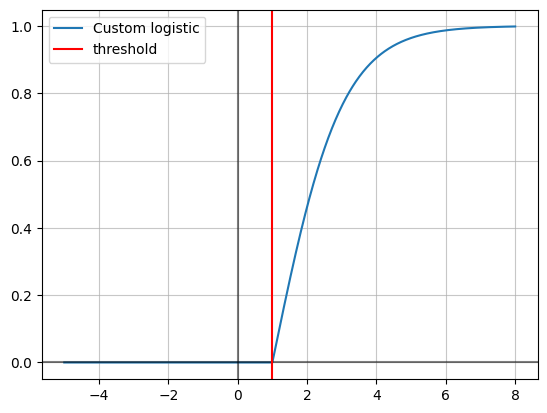

In [ ]:
# Custom logistic function
threshold = 1
k = 1
gamma1 = 0.1
gamma2 = 0.9

f = lambda x: 2. / (1. + np.exp(-k * (x - threshold))) - 1

x = np.linspace(-5, 8, 1000)
S = np.clip(f(x), 0, 1)

y = gamma1 + (gamma2 - gamma1) * S

plt.plot(x, S, label='Custom logistic')
plt.axhline(0, c='black', alpha=0.5)
plt.axvline(0, c='black', alpha=0.5)
plt.axvline(threshold, label='threshold', c='r')
plt.grid(alpha=0.7)
plt.legend()
plt.show()